# Project description

This dataset was provided by Una Health.<br> 
The main objective of this data challenge is to visualise blood glucose levels and find
connections between the blood glucose levels and tracked meals. <br>
<br>

### Data
The data consists of:
- A csv file with the historic blood glucose levels of the patient: levels_all.csv . We're interested in blood glucose readings which have an Aufzeichnungstyp of either 0 or 1 (those appear in different columns because they are different types, automatically collected every 15 minutes vs. manual scanned by the patient, but are readings from the same sensor and thus should be treated as such). The blood glucose reading is noted in Glukosewert-Verlauf mg/dL or Glukose-Scan mg/dL . All timestamps noted in this file are UTC. 
- A csv file with the tracked meals of the patient: activities_all.csv . Each meal is identified by a UUID.

You can download the sample data from here: https://s3-de-central.profitbricks.com/una-health-data-challenge/una-health-data-challenge.zip

### Tasks

##### Visualise 
Create plots for the historic blood glucose level by each patient and the historic blood glucose level after meals (we usually look at timestamp_start of the meal + 3 hours worth of data). Feel free to group and slice the data for the individual meals as you see fit.

##### Interpret 
What conclusions can you draw when looking at the combined data of historic blood glucose levels and tracked meals for an individual patient and for certain meal types of an individual patient? What clusters (if any) do you find? 
What additional information (if any) do you need? What clustering methods would you apply?

##### Evaluation Criteria
General: selected and explained chosen software design and libraries, used clean code structure, followed and explained coding conventions
<br>
Algorithms and data structures: explained the approach and thinking and methods used, clarified variety and suitability of methods and algorithms used, explained selected data structure
<br>
Documentation: added clear inline & high-level documentation, added documentation on how to start & run the submitted solution
<br>
We evaluate your communication with us

# Instructions to set-up environment 

In order to be able to run this notebook without issues, please configure the  environment according to the instructions provided. 

By following the below steps, you should be able to reproduce the results seen in this notebook.

1. In terminal, navigate to the project folder where this notebook is stored as well as the requirements.txt file that is included in the github repository. Once there, type this:
- virtualenv venv

2. Next, while still in the project folder, type this:
- source venv/bin/activate - for Linux/MacOS (Unix)
- venv/Scripts/activate - for Windows


3. Now, if you’ve downloaded this project, and create a virtual environment with the instructions above, you’ll be able to fill it with all the packages it needs by just typing:
- pip install -r requirements.txt


# Import packages

In [238]:
import os
from pathlib import Path
from math import ceil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import classification_report, confusion_matrix, precision_score
import random
import numpy as np
import pandas as pd
import scipy.stats as stats 
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.gridspec as gspec
import matplotlib.cm as cm
import seaborn as sns
import re
import sklearn.preprocessing as prep
import sklearn.impute as imp
import sklearn.covariance as cov
from datetime import datetime, date
from scipy.cluster.hierarchy import dendrogram, linkage, set_link_color_palette
from sklearn.cluster import AgglomerativeClustering, KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.mixture import GaussianMixture
from numpy.linalg import svd
from scipy.spatial import distance_matrix
from scipy.stats import chi2
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import MeanShift, DBSCAN, estimate_bandwidth
from sklearn.impute import KNNImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import requests
from zipfile import ZipFile
from io import BytesIO
import plotly.express as px
import phik

'''This has to be installed to run Self-Organizing Maps section'''
# install sompy (use our forked version - the original one has visualization bugs)
#!conda install git
#!pip install -U git+https://github.com/joaopfonseca/SOMPY.git

import sompy
from sompy.visualization.mapview import View2D
from sompy.visualization.bmuhits import BmuHitsView
from sompy.visualization.hitmap import HitMapView

%matplotlib inline
%config InlineBackend.figure_format = 'retina' #better quality of visualisations

import warnings
warnings.filterwarnings('ignore')

# Import Data

In [239]:
#Function to create customers based on the id logic
def create_customer(x):
    return 8*x+'-'+4*x+'-'+4*x+'-'+4*x+'-'+12*x       

In [240]:
#Put customers in a list
list_customers = []

for character in ['a', 'b', 'c']:
    this_customer = create_customer(character)
    list_customers.append(this_customer)    

In [241]:
#Connect to the url and unzip the file
r = requests.get("https://s3-de-central.profitbricks.com/una-health-data-challenge/una-health-data-challenge.zip")
files = ZipFile(BytesIO(r.content))

In [242]:
#Go through each customer and read the respective csv 
df_activities = pd.read_csv(files.open(list_customers[0]+'/activities_all.csv'), encoding='utf-8')
df_levels = pd.read_csv(files.open(list_customers[0]+'/levels_all.csv'), encoding='utf-8', header=1)
df_levels['user_id'] = list_customers[0]

for customer in list_customers[1:]:
    this_customer_activities = pd.read_csv(files.open(customer+'/activities_all.csv'), 
                                           encoding='utf-8')
    this_customer_levels = pd.read_csv(files.open(customer+'/levels_all.csv'), 
                                           encoding='utf-8', header=1)
    this_customer_levels['user_id'] = customer
    df_activities = pd.concat([df_activities, this_customer_activities])
    df_levels = pd.concat([df_levels, this_customer_levels])

In [243]:
df_activities.head()

,id,user_id,record_type,description,timestamp_start,timestamp_end,payload,created,last_modified
0,aaaaaaaa-aaaa-aaaa-aaaa-aaaaaaaaaa00,aaaaaaaa-aaaa-aaaa-aaaa-aaaaaaaaaaaa,MEAL_BREAKFAST,"40 g Haferflocken, 230 g Joghurt 0,3 %, 90 g B...",2021-02-15T08:30:00+01:00,NaN,NaN,NaN,NaN
1,aaaaaaaa-aaaa-aaaa-aaaa-aaaaaaaaaa01,aaaaaaaa-aaaa-aaaa-aaaa-aaaaaaaaaaaa,MEAL_LUNCH,"98 g M�hren-Walnuss-VK-Brot, 87 g Gurke, 55 g ...",2021-02-15T12:45:00+01:00,NaN,NaN,NaN,NaN
2,aaaaaaaa-aaaa-aaaa-aaaa-aaaaaaaaaa02,aaaaaaaa-aaaa-aaaa-aaaa-aaaaaaaaaaaa,MEAL_SNACK,"Mandarine, Teel�ffel Erdnussmu�",2021-02-15T16:15:00+01:00,NaN,NaN,NaN,NaN
3,aaaaaaaa-aaaa-aaaa-aaaa-aaaaaaaaaa03,aaaaaaaa-aaaa-aaaa-aaaa-aaaaaaaaaaaa,ACTVITY_EASY,spazieren,2021-02-15T17:00:00+01:00,2021-02-15T17:30:00+01:00,NaN,NaN,NaN
4,aaaaaaaa-aaaa-aaaa-aaaa-aaaaaaaaaa04,aaaaaaaa-aaaa-aaaa-aaaa-aaaaaaaaaaaa,MEAL_DINNER,"50 g BasmatiVollkorn Reis, 20g Currypaste, 15 ...",2021-02-15T19:30:00+01:00,NaN,NaN,NaN,NaN


In [244]:
df_levels.head()

,Gerät,Seriennummer,Gerätezeitstempel,Aufzeichnungstyp,Glukosewert-Verlauf mg/dL,Glukose-Scan mg/dL,Nicht numerisches schnellwirkendes Insulin,Schnellwirkendes Insulin (Einheiten),Nicht numerische Nahrungsdaten,Kohlenhydrate (Gramm),Kohlenhydrate (Portionen),Nicht numerisches Depotinsulin,Depotinsulin (Einheiten),Notizen,Glukose-Teststreifen mg/dL,Keton mmol/L,Mahlzeiteninsulin (Einheiten),Korrekturinsulin (Einheiten),Insulin-Änderung durch Anwender (Einheiten),user_id
0,FreeStyle LibreLink,1D48A10E-DDFB-4888-8158-026F08814832,18-02-2021 10:57,0,77.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,aaaaaaaa-aaaa-aaaa-aaaa-aaaaaaaaaaaa
1,FreeStyle LibreLink,1D48A10E-DDFB-4888-8158-026F08814832,18-02-2021 11:12,0,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,aaaaaaaa-aaaa-aaaa-aaaa-aaaaaaaaaaaa
2,FreeStyle LibreLink,1D48A10E-DDFB-4888-8158-026F08814832,18-02-2021 11:27,0,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,aaaaaaaa-aaaa-aaaa-aaaa-aaaaaaaaaaaa
3,FreeStyle LibreLink,1D48A10E-DDFB-4888-8158-026F08814832,18-02-2021 11:42,0,76.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,aaaaaaaa-aaaa-aaaa-aaaa-aaaaaaaaaaaa
4,FreeStyle LibreLink,1D48A10E-DDFB-4888-8158-026F08814832,18-02-2021 11:57,0,75.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,aaaaaaaa-aaaa-aaaa-aaaa-aaaaaaaaaaaa


# Quick assessment

In [245]:
df_activities.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38 entries, 0 to 6
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               38 non-null     object 
 1   user_id          38 non-null     object 
 2   record_type      38 non-null     object 
 3   description      38 non-null     object 
 4   timestamp_start  38 non-null     object 
 5   timestamp_end    2 non-null      object 
 6   payload          0 non-null      float64
 7   created          0 non-null      float64
 8   last_modified    0 non-null      float64
dtypes: float64(3), object(6)
memory usage: 3.0+ KB


In [246]:
df_levels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3991 entries, 0 to 1422
Data columns (total 20 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Gerät                                        3991 non-null   object 
 1   Seriennummer                                 3991 non-null   object 
 2   Gerätezeitstempel                            3991 non-null   object 
 3   Aufzeichnungstyp                             3991 non-null   int64  
 4   Glukosewert-Verlauf mg/dL                    3579 non-null   float64
 5   Glukose-Scan mg/dL                           345 non-null    float64
 6   Nicht numerisches schnellwirkendes Insulin   0 non-null      float64
 7   Schnellwirkendes Insulin (Einheiten)         0 non-null      float64
 8   Nicht numerische Nahrungsdaten               1 non-null      float64
 9   Kohlenhydrate (Gramm)                        0 non-null      float64
 10  

# Data Preprocessing

#### First the activities

In [247]:
df_activities_clean = df_activities.copy()

#keep only rows about meals
activities_to_keep = ['MEAL_DINNER', 'MEAL_LUNCH', 'MEAL_SNACK', 'MEAL_BREAKFAST']
df_activities_clean = df_activities_clean[df_activities_clean['record_type'].isin(activities_to_keep)]

#remove empty columns
df_activities_clean = df_activities_clean.iloc[:,:-4] 

#format datetime as timestamp
df_activities_clean['timestamp_start'] = df_activities_clean['timestamp_start'].apply(lambda x: pd.Timestamp(x[:-6]))

#add timestamp for 3h after meal
df_activities_clean['timestamp_aftermeal'] = df_activities_clean['timestamp_start'].apply(lambda x: x+pd.Timedelta(hours=3))


df_activities_clean.head()


,id,user_id,record_type,description,timestamp_start,timestamp_aftermeal
0,aaaaaaaa-aaaa-aaaa-aaaa-aaaaaaaaaa00,aaaaaaaa-aaaa-aaaa-aaaa-aaaaaaaaaaaa,MEAL_BREAKFAST,"40 g Haferflocken, 230 g Joghurt 0,3 %, 90 g B...",2021-02-15 08:30:00,2021-02-15 11:30:00
1,aaaaaaaa-aaaa-aaaa-aaaa-aaaaaaaaaa01,aaaaaaaa-aaaa-aaaa-aaaa-aaaaaaaaaaaa,MEAL_LUNCH,"98 g M�hren-Walnuss-VK-Brot, 87 g Gurke, 55 g ...",2021-02-15 12:45:00,2021-02-15 15:45:00
2,aaaaaaaa-aaaa-aaaa-aaaa-aaaaaaaaaa02,aaaaaaaa-aaaa-aaaa-aaaa-aaaaaaaaaaaa,MEAL_SNACK,"Mandarine, Teel�ffel Erdnussmu�",2021-02-15 16:15:00,2021-02-15 19:15:00
4,aaaaaaaa-aaaa-aaaa-aaaa-aaaaaaaaaa04,aaaaaaaa-aaaa-aaaa-aaaa-aaaaaaaaaaaa,MEAL_DINNER,"50 g BasmatiVollkorn Reis, 20g Currypaste, 15 ...",2021-02-15 19:30:00,2021-02-15 22:30:00
5,aaaaaaaa-aaaa-aaaa-aaaa-aaaaaaaaaa05,aaaaaaaa-aaaa-aaaa-aaaa-aaaaaaaaaaaa,MEAL_BREAKFAST,"230 g Joghurt, 40g Haferflocken, 65 g Apfel",2021-02-17 08:15:00,2021-02-17 11:15:00


Looking at the levels dataframe

In [248]:
df_levels_clean = df_levels.copy()

#only Aufzeichnungstyp of 0 or 1
df_levels_clean = df_levels_clean[df_levels_clean['Aufzeichnungstyp'].isin([0,1])]

#Combine the info from verlauf and scan
df_levels_clean['Glukosewert-Verlauf mg/dL'] = df_levels_clean['Glukosewert-Verlauf mg/dL'].fillna(df_levels_clean['Glukose-Scan mg/dL'])

#Keep only columns with info
df_levels_clean = df_levels_clean[['user_id', 'Gerätezeitstempel', 'Aufzeichnungstyp', 'Glukosewert-Verlauf mg/dL']]

#Recode datetime as timestamp
df_levels_clean['timestamp'] = df_levels_clean['Gerätezeitstempel'].apply(lambda x: pd.Timestamp(x))

#Keep only the columns we are interested in
df_levels_clean = df_levels_clean[['user_id', 'timestamp', 'Aufzeichnungstyp', 'Glukosewert-Verlauf mg/dL']]

df_levels_clean

,user_id,timestamp,Aufzeichnungstyp,Glukosewert-Verlauf mg/dL
0,aaaaaaaa-aaaa-aaaa-aaaa-aaaaaaaaaaaa,2021-02-18 10:57:00,0,77.0
1,aaaaaaaa-aaaa-aaaa-aaaa-aaaaaaaaaaaa,2021-02-18 11:12:00,0,78.0
2,aaaaaaaa-aaaa-aaaa-aaaa-aaaaaaaaaaaa,2021-02-18 11:27:00,0,78.0
3,aaaaaaaa-aaaa-aaaa-aaaa-aaaaaaaaaaaa,2021-02-18 11:42:00,0,76.0
4,aaaaaaaa-aaaa-aaaa-aaaa-aaaaaaaaaaaa,2021-02-18 11:57:00,0,75.0
...,...,...,...,...
1407,cccccccc-cccc-cccc-cccc-cccccccccccc,2021-02-23 20:18:00,1,106.0
1408,cccccccc-cccc-cccc-cccc-cccccccccccc,2021-02-23 21:29:00,1,108.0
1409,cccccccc-cccc-cccc-cccc-cccccccccccc,2021-02-24 04:12:00,1,113.0
1410,cccccccc-cccc-cccc-cccc-cccccccccccc,2021-02-24 07:17:00,1,134.0


Now we want to merge glucose levels information to the meals dataframe

In [249]:
#Function to search for glucose level prior to meal start

def get_glucose_before_meal_a(x):
    #Search for this user's glucose levels in df_levels and sort by time
    df_to_search = df_levels_clean[df_levels_clean['user_id']==create_customer('a')]
    df_to_search = df_to_search.sort_values(by='timestamp')
    #Return the last glucose measurement prior to the meal start
    return df_to_search[df_to_search['timestamp']<x].iloc[-1:,]['Glukosewert-Verlauf mg/dL'].iloc[0]

#Bad solution (should be integrated in the function but time was running out! and I only noticed in the end...)
def get_glucose_before_meal_b(x):
    df_to_search = df_levels_clean[df_levels_clean['user_id']==create_customer('b')]
    df_to_search = df_to_search.sort_values(by='timestamp')
    return df_to_search[df_to_search['timestamp']<x].iloc[-1:,]['Glukosewert-Verlauf mg/dL'].iloc[0]

def get_glucose_before_meal_c(x):
    df_to_search = df_levels_clean[df_levels_clean['user_id']==create_customer('c')]
    df_to_search = df_to_search.sort_values(by='timestamp')
    return df_to_search[df_to_search['timestamp']<x].iloc[-1:,]['Glukosewert-Verlauf mg/dL'].iloc[0]

In [250]:
#Function to look for the max of glucose level in the 3h following meal start

def get_glucose_after_meal_a(x):
    #Search for this user's glucose levels in df_levels and sort by time
    df_to_search = df_levels_clean[(df_levels_clean['user_id']==create_customer('a')) & (df_levels_clean['timestamp']>x-pd.Timedelta(hours=3))]
    df_to_search = df_to_search.sort_values(by='timestamp')
    #Return the highest value found in that interval
    return df_to_search[df_to_search['timestamp']<x]['Glukosewert-Verlauf mg/dL'].max()

#Bad solution (should be integrated in the function but time was running out! and I only noticed in the end...)
def get_glucose_after_meal_b(x):
    df_to_search = df_levels_clean[(df_levels_clean['user_id']==create_customer('b')) & (df_levels_clean['timestamp']>x-pd.Timedelta(hours=3))]
    df_to_search = df_to_search.sort_values(by='timestamp')
    return df_to_search[df_to_search['timestamp']<x]['Glukosewert-Verlauf mg/dL'].max()

def get_glucose_after_meal_c(x):
    df_to_search = df_levels_clean[(df_levels_clean['user_id']==create_customer('c')) & (df_levels_clean['timestamp']>x-pd.Timedelta(hours=3))]
    df_to_search = df_to_search.sort_values(by='timestamp')
    return df_to_search[df_to_search['timestamp']<x]['Glukosewert-Verlauf mg/dL'].max()

In [251]:
#Function to look for the time at which the glucose was at the highest level in the 3h following the meal

def get_glucose_after_meal_spike_time_a(x):
    #Search for this user's glucose levels in df_levels and sort by time
    df_to_search = df_levels_clean[(df_levels_clean['user_id']==create_customer('a')) & (df_levels_clean['timestamp']>x-pd.Timedelta(hours=3))]
    df_to_search = df_to_search.sort_values(by='timestamp')
    #Return the highest value found in that interval
    max_index = df_to_search[df_to_search['timestamp']<x]['Glukosewert-Verlauf mg/dL'].idxmax()
    return df_to_search.loc[max_index]['timestamp']

def get_glucose_after_meal_spike_time_b(x):
    #Search for this user's glucose levels in df_levels and sort by time
    df_to_search = df_levels_clean[(df_levels_clean['user_id']==create_customer('b')) & (df_levels_clean['timestamp']>x-pd.Timedelta(hours=3))]
    df_to_search = df_to_search.sort_values(by='timestamp')
    #Return the highest value found in that interval
    max_index = df_to_search[df_to_search['timestamp']<x]['Glukosewert-Verlauf mg/dL'].idxmax()
    return df_to_search.loc[max_index]['timestamp']

def get_glucose_after_meal_spike_time_c(x):
    #Search for this user's glucose levels in df_levels and sort by time
    df_to_search = df_levels_clean[(df_levels_clean['user_id']==create_customer('c')) & (df_levels_clean['timestamp']>x-pd.Timedelta(hours=3))]
    df_to_search = df_to_search.sort_values(by='timestamp')
    #Return the highest value found in that interval
    max_index = df_to_search[df_to_search['timestamp']<x]['Glukosewert-Verlauf mg/dL'].idxmax()
    return df_to_search.loc[max_index]['timestamp']

In [252]:
#Applying functions to get glucose levels (each user at a time)
df_activities_a = df_activities_clean[df_activities_clean['user_id']==create_customer('a')]
df_activities_a['glucose_start'] = df_activities_a['timestamp_start'].apply(get_glucose_before_meal_a)
df_activities_a['glucose_after'] = df_activities_a['timestamp_aftermeal'].apply(get_glucose_after_meal_a)
df_activities_a['peak time'] = df_activities_a['timestamp_aftermeal'].apply(get_glucose_after_meal_spike_time_a)
df_activities_a['minutes until peak'] = (df_activities_a['peak time']-df_activities_a['timestamp_start']).astype('timedelta64[m]')
df_activities_a.head()

,id,user_id,record_type,description,timestamp_start,timestamp_aftermeal,glucose_start,glucose_after,peak time,minutes until peak
0,aaaaaaaa-aaaa-aaaa-aaaa-aaaaaaaaaa00,aaaaaaaa-aaaa-aaaa-aaaa-aaaaaaaaaaaa,MEAL_BREAKFAST,"40 g Haferflocken, 230 g Joghurt 0,3 %, 90 g B...",2021-02-15 08:30:00,2021-02-15 11:30:00,80.0,109.0,2021-02-15 08:55:00,25.0
1,aaaaaaaa-aaaa-aaaa-aaaa-aaaaaaaaaa01,aaaaaaaa-aaaa-aaaa-aaaa-aaaaaaaaaaaa,MEAL_LUNCH,"98 g M�hren-Walnuss-VK-Brot, 87 g Gurke, 55 g ...",2021-02-15 12:45:00,2021-02-15 15:45:00,83.0,121.0,2021-02-15 13:44:00,59.0
2,aaaaaaaa-aaaa-aaaa-aaaa-aaaaaaaaaa02,aaaaaaaa-aaaa-aaaa-aaaa-aaaaaaaaaaaa,MEAL_SNACK,"Mandarine, Teel�ffel Erdnussmu�",2021-02-15 16:15:00,2021-02-15 19:15:00,73.0,102.0,2021-02-15 16:57:00,42.0
4,aaaaaaaa-aaaa-aaaa-aaaa-aaaaaaaaaa04,aaaaaaaa-aaaa-aaaa-aaaa-aaaaaaaaaaaa,MEAL_DINNER,"50 g BasmatiVollkorn Reis, 20g Currypaste, 15 ...",2021-02-15 19:30:00,2021-02-15 22:30:00,73.0,101.0,2021-02-15 21:21:00,111.0
5,aaaaaaaa-aaaa-aaaa-aaaa-aaaaaaaaaa05,aaaaaaaa-aaaa-aaaa-aaaa-aaaaaaaaaaaa,MEAL_BREAKFAST,"230 g Joghurt, 40g Haferflocken, 65 g Apfel",2021-02-17 08:15:00,2021-02-17 11:15:00,78.0,108.0,2021-02-17 08:51:00,36.0


In [253]:
#Applying functions to get glucose levels (each user at a time)
df_activities_b = df_activities_clean[df_activities_clean['user_id']==create_customer('b')]
df_activities_b['glucose_start'] = df_activities_b['timestamp_start'].apply(get_glucose_before_meal_b)
df_activities_b['glucose_after'] = df_activities_b['timestamp_aftermeal'].apply(get_glucose_after_meal_b)
df_activities_b['peak time'] = df_activities_b['timestamp_aftermeal'].apply(get_glucose_after_meal_spike_time_b)
df_activities_b['minutes until peak'] = (df_activities_b['peak time']-df_activities_b['timestamp_start']).astype('timedelta64[m]')
df_activities_b.head()

,id,user_id,record_type,description,timestamp_start,timestamp_aftermeal,glucose_start,glucose_after,peak time,minutes until peak
0,bbbbbbbb-bbbb-bbbb-bbbb-bbbbbbbbbb00,bbbbbbbb-bbbb-bbbb-bbbb-bbbbbbbbbbbb,MEAL_BREAKFAST,2 Pott Kaffe +Zucker,2021-02-19 06:30:00,2021-02-19 09:30:00,148.0,171.0,2021-02-19 08:14:00,104.0
1,bbbbbbbb-bbbb-bbbb-bbbb-bbbbbbbbbb01,bbbbbbbb-bbbb-bbbb-bbbb-bbbbbbbbbbbb,MEAL_BREAKFAST,Gem�sesuppe instant,2021-02-19 07:30:00,2021-02-19 10:30:00,149.0,171.0,2021-02-19 08:14:00,44.0
2,bbbbbbbb-bbbb-bbbb-bbbb-bbbbbbbbbb02,bbbbbbbb-bbbb-bbbb-bbbb-bbbbbbbbbbbb,MEAL_SNACK,Gem�sesuppe instant + Gr�ner Tee ohne alles,2021-02-19 09:00:00,2021-02-19 12:00:00,136.0,157.0,2021-02-19 09:29:00,29.0
4,bbbbbbbb-bbbb-bbbb-bbbb-bbbbbbbbbb04,bbbbbbbb-bbbb-bbbb-bbbb-bbbbbbbbbbbb,MEAL_LUNCH,"Kartoffeln (150 g), Quark 250 g, Bohnen 250g ,...",2021-02-19 12:45:00,2021-02-19 15:45:00,104.0,138.0,2021-02-19 15:30:00,165.0
5,bbbbbbbb-bbbb-bbbb-bbbb-bbbbbbbbbb05,bbbbbbbb-bbbb-bbbb-bbbb-bbbbbbbbbbbb,MEAL_SNACK,"kaffee und etwas zucker, scheibe Brot mit L�tt...",2021-02-19 15:30:00,2021-02-19 18:30:00,130.0,156.0,2021-02-19 16:15:00,45.0


In [254]:
#Applying functions to get glucose levels (each user at a time)
df_activities_c = df_activities_clean[df_activities_clean['user_id']==create_customer('c')]
df_activities_c['glucose_start'] = df_activities_c['timestamp_start'].apply(get_glucose_before_meal_c)
df_activities_c['glucose_after'] = df_activities_c['timestamp_aftermeal'].apply(get_glucose_after_meal_c)
df_activities_c['peak time'] = df_activities_c['timestamp_aftermeal'].apply(get_glucose_after_meal_spike_time_c)
df_activities_c['minutes until peak'] = (df_activities_c['peak time']-df_activities_c['timestamp_start']).astype('timedelta64[m]')
df_activities_c.head()

,id,user_id,record_type,description,timestamp_start,timestamp_aftermeal,glucose_start,glucose_after,peak time,minutes until peak
0,cccccccc-cccc-cccc-cccc-cccccccccc00,cccccccc-cccc-cccc-cccc-cccccccccccc,MEAL_BREAKFAST,"3 Vollkorntoast, 75g Schmelzk�se, 35g Butter, ...",2021-02-17 06:00:00,2021-02-17 09:00:00,110.0,168.0,2021-02-17 07:16:00,76.0
1,cccccccc-cccc-cccc-cccc-cccccccccc01,cccccccc-cccc-cccc-cccc-cccccccccccc,MEAL_LUNCH,"350g Spinat,250g Kartoffeln, 2 Spiegeleier, 40...",2021-02-17 13:45:00,2021-02-17 16:45:00,108.0,163.0,2021-02-17 16:04:00,139.0
2,cccccccc-cccc-cccc-cccc-cccccccccc02,cccccccc-cccc-cccc-cccc-cccccccccccc,MEAL_DINNER,"1 Vollkornbrot, 25g Butter, 65g Romadur, 20g E...",2021-02-17 19:45:00,2021-02-17 22:45:00,93.0,128.0,2021-02-17 21:36:00,111.0
3,cccccccc-cccc-cccc-cccc-cccccccccc03,cccccccc-cccc-cccc-cccc-cccccccccccc,MEAL_LUNCH,"140g gebackener Leberk�se, 150g Erbsen-M�hren,...",2021-02-19 11:45:00,2021-02-19 14:45:00,145.0,169.0,2021-02-19 12:37:00,52.0
4,cccccccc-cccc-cccc-cccc-cccccccccc04,cccccccc-cccc-cccc-cccc-cccccccccccc,MEAL_DINNER,"1 Vollkornbr�tchen, 70g Leberk�se, 100g Mixed ...",2021-02-19 18:30:00,2021-02-19 21:30:00,117.0,184.0,2021-02-19 19:41:00,71.0


In [255]:
#Combining the customers back into a single dataframe
df_activities_ready = pd.concat([df_activities_a, df_activities_b, df_activities_c])

#Adding column for difference in glucose between start and after meal
df_activities_ready['change_aftermeal'] = df_activities_ready['glucose_after'] - df_activities_ready['glucose_start']

#Adding column for pct difference
df_activities_ready['pct_change_aftermeal'] = round((df_activities_ready['glucose_after'] - df_activities_ready['glucose_start'])/df_activities_ready['glucose_start'],4)*100

#Adding column for number of ingredients in meal
df_activities_ready['number of components'] = df_activities_ready['description'].apply(lambda x: len(x.split(',')))

#Cleaning type of meal
df_activities_ready['record_type'] = df_activities_ready['record_type'].apply(lambda x: x.split('_')[-1])


df_activities_ready.head()

,id,user_id,record_type,description,timestamp_start,timestamp_aftermeal,glucose_start,glucose_after,peak time,minutes until peak,change_aftermeal,pct_change_aftermeal,number of components
0,aaaaaaaa-aaaa-aaaa-aaaa-aaaaaaaaaa00,aaaaaaaa-aaaa-aaaa-aaaa-aaaaaaaaaaaa,BREAKFAST,"40 g Haferflocken, 230 g Joghurt 0,3 %, 90 g B...",2021-02-15 08:30:00,2021-02-15 11:30:00,80.0,109.0,2021-02-15 08:55:00,25.0,29.0,36.25,5
1,aaaaaaaa-aaaa-aaaa-aaaa-aaaaaaaaaa01,aaaaaaaa-aaaa-aaaa-aaaa-aaaaaaaaaaaa,LUNCH,"98 g M�hren-Walnuss-VK-Brot, 87 g Gurke, 55 g ...",2021-02-15 12:45:00,2021-02-15 15:45:00,83.0,121.0,2021-02-15 13:44:00,59.0,38.0,45.78,4
2,aaaaaaaa-aaaa-aaaa-aaaa-aaaaaaaaaa02,aaaaaaaa-aaaa-aaaa-aaaa-aaaaaaaaaaaa,SNACK,"Mandarine, Teel�ffel Erdnussmu�",2021-02-15 16:15:00,2021-02-15 19:15:00,73.0,102.0,2021-02-15 16:57:00,42.0,29.0,39.73,2
4,aaaaaaaa-aaaa-aaaa-aaaa-aaaaaaaaaa04,aaaaaaaa-aaaa-aaaa-aaaa-aaaaaaaaaaaa,DINNER,"50 g BasmatiVollkorn Reis, 20g Currypaste, 15 ...",2021-02-15 19:30:00,2021-02-15 22:30:00,73.0,101.0,2021-02-15 21:21:00,111.0,28.0,38.36,12
5,aaaaaaaa-aaaa-aaaa-aaaa-aaaaaaaaaa05,aaaaaaaa-aaaa-aaaa-aaaa-aaaaaaaaaaaa,BREAKFAST,"230 g Joghurt, 40g Haferflocken, 65 g Apfel",2021-02-17 08:15:00,2021-02-17 11:15:00,78.0,108.0,2021-02-17 08:51:00,36.0,30.0,38.46,3


Creating a dataframe that contains one line per meal component

In [256]:
#Trying to get the quantity of each component
def get_quantity(x):
    quantity = '0'
    for n in range(len(x)):
        if str(x[n]) in ['0','1','2','3','4','5','6','7','8', '9']:
            quantity+=x[n]
    return float(quantity)
            

In [257]:
df_activities_meal_components = df_activities_ready.copy()

#Separating components based on commas and exploding to create new rows
df_activities_meal_components['meal component'] = df_activities_meal_components['description'].apply(lambda x: x.split(','))
df_activities_meal_components = df_activities_meal_components.explode('meal component')

#Getting the quantity of each component
df_activities_meal_components['Quantity'] = df_activities_meal_components['meal component'].apply(get_quantity)

#Getting only the name by splitting based on the spaces
df_activities_meal_components['meal component'] = df_activities_meal_components['meal component'].apply(lambda x: x.split(' ')[-1])

df_activities_meal_components.tail()

,id,user_id,record_type,description,timestamp_start,timestamp_aftermeal,glucose_start,glucose_after,peak time,minutes until peak,change_aftermeal,pct_change_aftermeal,number of components,meal component,Quantity
6,cccccccc-cccc-cccc-cccc-cccccccccc06,cccccccc-cccc-cccc-cccc-cccccccccccc,DINNER,"1 Schb. Vollkorndinkelbrot, 30g Butter, 100g K...",2021-02-21 18:00:00,2021-02-21 21:00:00,100.0,156.0,2021-02-21 19:13:00,73.0,56.0,56.0,5,Vollkorndinkelbrot,1.0
6,cccccccc-cccc-cccc-cccc-cccccccccc06,cccccccc-cccc-cccc-cccc-cccccccccccc,DINNER,"1 Schb. Vollkorndinkelbrot, 30g Butter, 100g K...",2021-02-21 18:00:00,2021-02-21 21:00:00,100.0,156.0,2021-02-21 19:13:00,73.0,56.0,56.0,5,Butter,30.0
6,cccccccc-cccc-cccc-cccc-cccccccccc06,cccccccc-cccc-cccc-cccc-cccccccccccc,DINNER,"1 Schb. Vollkorndinkelbrot, 30g Butter, 100g K...",2021-02-21 18:00:00,2021-02-21 21:00:00,100.0,156.0,2021-02-21 19:13:00,73.0,56.0,56.0,5,Kartoffelsalat,100.0
6,cccccccc-cccc-cccc-cccc-cccccccccc06,cccccccc-cccc-cccc-cccc-cccccccccccc,DINNER,"1 Schb. Vollkorndinkelbrot, 30g Butter, 100g K...",2021-02-21 18:00:00,2021-02-21 21:00:00,100.0,156.0,2021-02-21 19:13:00,73.0,56.0,56.0,5,Tomatensalat,100.0
6,cccccccc-cccc-cccc-cccc-cccccccccc06,cccccccc-cccc-cccc-cccc-cccccccccccc,DINNER,"1 Schb. Vollkorndinkelbrot, 30g Butter, 100g K...",2021-02-21 18:00:00,2021-02-21 21:00:00,100.0,156.0,2021-02-21 19:13:00,73.0,56.0,56.0,5,Rotwein,400.0


### Note: Advanced text mining is not my stronger suit so if that is very important for the short-term, I might not be the person you are looking for! I can learn though but I am no expert at the moment in the libraries that can make magic happen :)

# Visualizing data with Plotly

#### Important note
All the observations made here are purely exploratory and intend only to demonstrate how the visualisations could help in finding hypothesis that would have to be verified with further investigation.

In [258]:
df_levels_clean.head()

,user_id,timestamp,Aufzeichnungstyp,Glukosewert-Verlauf mg/dL
0,aaaaaaaa-aaaa-aaaa-aaaa-aaaaaaaaaaaa,2021-02-18 10:57:00,0,77.0
1,aaaaaaaa-aaaa-aaaa-aaaa-aaaaaaaaaaaa,2021-02-18 11:12:00,0,78.0
2,aaaaaaaa-aaaa-aaaa-aaaa-aaaaaaaaaaaa,2021-02-18 11:27:00,0,78.0
3,aaaaaaaa-aaaa-aaaa-aaaa-aaaaaaaaaaaa,2021-02-18 11:42:00,0,76.0
4,aaaaaaaa-aaaa-aaaa-aaaa-aaaaaaaaaaaa,2021-02-18 11:57:00,0,75.0


In [259]:
df_activities_ready.head()

,id,user_id,record_type,description,timestamp_start,timestamp_aftermeal,glucose_start,glucose_after,peak time,minutes until peak,change_aftermeal,pct_change_aftermeal,number of components
0,aaaaaaaa-aaaa-aaaa-aaaa-aaaaaaaaaa00,aaaaaaaa-aaaa-aaaa-aaaa-aaaaaaaaaaaa,BREAKFAST,"40 g Haferflocken, 230 g Joghurt 0,3 %, 90 g B...",2021-02-15 08:30:00,2021-02-15 11:30:00,80.0,109.0,2021-02-15 08:55:00,25.0,29.0,36.25,5
1,aaaaaaaa-aaaa-aaaa-aaaa-aaaaaaaaaa01,aaaaaaaa-aaaa-aaaa-aaaa-aaaaaaaaaaaa,LUNCH,"98 g M�hren-Walnuss-VK-Brot, 87 g Gurke, 55 g ...",2021-02-15 12:45:00,2021-02-15 15:45:00,83.0,121.0,2021-02-15 13:44:00,59.0,38.0,45.78,4
2,aaaaaaaa-aaaa-aaaa-aaaa-aaaaaaaaaa02,aaaaaaaa-aaaa-aaaa-aaaa-aaaaaaaaaaaa,SNACK,"Mandarine, Teel�ffel Erdnussmu�",2021-02-15 16:15:00,2021-02-15 19:15:00,73.0,102.0,2021-02-15 16:57:00,42.0,29.0,39.73,2
4,aaaaaaaa-aaaa-aaaa-aaaa-aaaaaaaaaa04,aaaaaaaa-aaaa-aaaa-aaaa-aaaaaaaaaaaa,DINNER,"50 g BasmatiVollkorn Reis, 20g Currypaste, 15 ...",2021-02-15 19:30:00,2021-02-15 22:30:00,73.0,101.0,2021-02-15 21:21:00,111.0,28.0,38.36,12
5,aaaaaaaa-aaaa-aaaa-aaaa-aaaaaaaaaa05,aaaaaaaa-aaaa-aaaa-aaaa-aaaaaaaaaaaa,BREAKFAST,"230 g Joghurt, 40g Haferflocken, 65 g Apfel",2021-02-17 08:15:00,2021-02-17 11:15:00,78.0,108.0,2021-02-17 08:51:00,36.0,30.0,38.46,3


In [260]:
df_activities_meal_components.tail()

,id,user_id,record_type,description,timestamp_start,timestamp_aftermeal,glucose_start,glucose_after,peak time,minutes until peak,change_aftermeal,pct_change_aftermeal,number of components,meal component,Quantity
6,cccccccc-cccc-cccc-cccc-cccccccccc06,cccccccc-cccc-cccc-cccc-cccccccccccc,DINNER,"1 Schb. Vollkorndinkelbrot, 30g Butter, 100g K...",2021-02-21 18:00:00,2021-02-21 21:00:00,100.0,156.0,2021-02-21 19:13:00,73.0,56.0,56.0,5,Vollkorndinkelbrot,1.0
6,cccccccc-cccc-cccc-cccc-cccccccccc06,cccccccc-cccc-cccc-cccc-cccccccccccc,DINNER,"1 Schb. Vollkorndinkelbrot, 30g Butter, 100g K...",2021-02-21 18:00:00,2021-02-21 21:00:00,100.0,156.0,2021-02-21 19:13:00,73.0,56.0,56.0,5,Butter,30.0
6,cccccccc-cccc-cccc-cccc-cccccccccc06,cccccccc-cccc-cccc-cccc-cccccccccccc,DINNER,"1 Schb. Vollkorndinkelbrot, 30g Butter, 100g K...",2021-02-21 18:00:00,2021-02-21 21:00:00,100.0,156.0,2021-02-21 19:13:00,73.0,56.0,56.0,5,Kartoffelsalat,100.0
6,cccccccc-cccc-cccc-cccc-cccccccccc06,cccccccc-cccc-cccc-cccc-cccccccccccc,DINNER,"1 Schb. Vollkorndinkelbrot, 30g Butter, 100g K...",2021-02-21 18:00:00,2021-02-21 21:00:00,100.0,156.0,2021-02-21 19:13:00,73.0,56.0,56.0,5,Tomatensalat,100.0
6,cccccccc-cccc-cccc-cccc-cccccccccc06,cccccccc-cccc-cccc-cccc-cccccccccccc,DINNER,"1 Schb. Vollkorndinkelbrot, 30g Butter, 100g K...",2021-02-21 18:00:00,2021-02-21 21:00:00,100.0,156.0,2021-02-21 19:13:00,73.0,56.0,56.0,5,Rotwein,400.0


#### Evolution of glucose for one user (a)

In [261]:
df = df_levels_clean[df_levels_clean['user_id']==create_customer('a')].sort_values(by='timestamp')
fig = px.line(df, x='timestamp', y="Glukosewert-Verlauf mg/dL")
fig.update_layout(template='plotly_dark')
fig.show()

In [262]:
df = df_levels_clean[df_levels_clean['user_id']==create_customer('a')].sort_values(by='timestamp')
df['day'] = df['timestamp'].dt.day
df['hour'] = df['timestamp'].dt.hour
df['glucose'] = df['Glukosewert-Verlauf mg/dL']

fig = px.line(df, x='hour', y="glucose", 
             facet_col="day", facet_col_wrap=2,
             title="Hourly evolution of glucose levels per day")
fig.update_layout(template='plotly_dark')

fig.show()

- Glucose levels ranged between 53 and 162 mg/dl for user 'a'
- Althought we are able to see a general trend of 3 spikes a day that should correspod to the periods after the 3 major meals, it is also possible to observe differences in glucose levels variability across days. For example, on the 20th and 22th the night peak seems less steep when compared to days 16 or 18. Would be interesting to explore what changed in terms of meals on those dates.
- Since the days for which we have meal data (15, 17 and 19) seem to show a similar pattern in glucose variability, we would expect that the meal composition and schedule would also be similar on those days

#### Are there differences in the impact of different meal types on glucose levels?

In [316]:
df = pd.melt(df_activities_ready[df_activities_ready['user_id']==create_customer('a')], 
             id_vars=['user_id', 'record_type', 'timestamp_start'], value_vars=['glucose_start', 'glucose_after'])

df['Glucose level'] = df['value']
df['Meal type'] = df['record_type']
df['Type of measurement'] = df['variable'].apply(lambda x: 'Before the meal' if x=='glucose_start' else 'Max in 3h after meal')

fig = px.box(df, x="Meal type", y="Glucose level", color="Type of measurement",
             title="Distribution of glucose levels before and after meal by meal type",
            )
fig.update_layout(template='plotly_dark')
fig.show()

- For this user, Glucose levels both before and after a meal seem to be more consistent in the morning.
- After dinner glucose levels seem to show the greatest variability inthe period analyzed.
- Snacks seem to have the least impact on glucose levels for this user.

#### Is there variability in the impact on glucose levels of the same meal type for the same individual?

In [264]:
df_activities_ready['day'] = df_activities_ready['timestamp_start'].dt.day
df_activities_ready.head()

,id,user_id,record_type,description,timestamp_start,timestamp_aftermeal,glucose_start,glucose_after,peak time,minutes until peak,change_aftermeal,pct_change_aftermeal,number of components,day
0,aaaaaaaa-aaaa-aaaa-aaaa-aaaaaaaaaa00,aaaaaaaa-aaaa-aaaa-aaaa-aaaaaaaaaaaa,BREAKFAST,"40 g Haferflocken, 230 g Joghurt 0,3 %, 90 g B...",2021-02-15 08:30:00,2021-02-15 11:30:00,80.0,109.0,2021-02-15 08:55:00,25.0,29.0,36.25,5,15
1,aaaaaaaa-aaaa-aaaa-aaaa-aaaaaaaaaa01,aaaaaaaa-aaaa-aaaa-aaaa-aaaaaaaaaaaa,LUNCH,"98 g M�hren-Walnuss-VK-Brot, 87 g Gurke, 55 g ...",2021-02-15 12:45:00,2021-02-15 15:45:00,83.0,121.0,2021-02-15 13:44:00,59.0,38.0,45.78,4,15
2,aaaaaaaa-aaaa-aaaa-aaaa-aaaaaaaaaa02,aaaaaaaa-aaaa-aaaa-aaaa-aaaaaaaaaaaa,SNACK,"Mandarine, Teel�ffel Erdnussmu�",2021-02-15 16:15:00,2021-02-15 19:15:00,73.0,102.0,2021-02-15 16:57:00,42.0,29.0,39.73,2,15
4,aaaaaaaa-aaaa-aaaa-aaaa-aaaaaaaaaa04,aaaaaaaa-aaaa-aaaa-aaaa-aaaaaaaaaaaa,DINNER,"50 g BasmatiVollkorn Reis, 20g Currypaste, 15 ...",2021-02-15 19:30:00,2021-02-15 22:30:00,73.0,101.0,2021-02-15 21:21:00,111.0,28.0,38.36,12,15
5,aaaaaaaa-aaaa-aaaa-aaaa-aaaaaaaaaa05,aaaaaaaa-aaaa-aaaa-aaaa-aaaaaaaaaaaa,BREAKFAST,"230 g Joghurt, 40g Haferflocken, 65 g Apfel",2021-02-17 08:15:00,2021-02-17 11:15:00,78.0,108.0,2021-02-17 08:51:00,36.0,30.0,38.46,3,17


In [265]:
df = df_activities_ready[df_activities_ready['user_id']==create_customer('a')]
df['Percentage change in glucose after the meal'] = df['change_aftermeal']
df['Type of meal'] = df['record_type']

fig = px.box(df, x="Type of meal", y="Percentage change in glucose after the meal", color="day",
             title="Variability of glucose levels before and after meal by day and meal type",
            )
fig.update_layout(template='plotly_dark')

fig.show()

- The effect of breakfast on glucose levels seems to be most stable for the 3 days of data available, followed by lunch.
- For snacks and dinner, it seems that the the different meals had a very different impact on the days available.
- Possibly the snack on the 19th and dinner of the 15th are better options than the others.

In [266]:
df = df_activities_ready[df_activities_ready['user_id']==create_customer('a')]
df['Percentage change in glucose after the meal'] = df['change_aftermeal']
df['Type of meal'] = df['record_type']

fig = px.box(df, x="Type of meal", y="minutes until peak", color="day",
             title="Variability of time until glucose peak (minutes) by day and meal type",
            )
fig.update_layout(template='plotly_dark')

fig.show()

#### Is there a relationship between the meal quantity and its impact on glucose levels?

In [267]:
df = df_activities_meal_components.groupby(['id','user_id', 'record_type'],
                                           as_index=False).agg({'Quantity': ['sum'], 
                                                                'pct_change_aftermeal': 'mean',
                                                                'minutes until peak': 'mean'})
df.columns = df.columns.droplevel(1)

df = df[df['Quantity']<4000]
df['Percentage change in glucose after the meal'] = df['pct_change_aftermeal']
df['Type of meal'] = df['record_type']
df['Time until glucose peak (minutes)'] = df['minutes until peak']
df['Meal size'] = df['Quantity']

fig = px.scatter(df, x="Time until glucose peak (minutes)", y="Percentage change in glucose after the meal",
                 size="Meal size", color="Type of meal",
                 hover_name="id", log_x=False, size_max=60,
                 title='Relationship between the change in glucose levels and the time to glucose peak by meal type and meal size')

fig.update_layout(template='plotly_dark')

fig.show()

- It seems that the varibales are positively correlated, the more time it took to recah the peak glucose, the higher the change in glucose was.
- After breakfast, it seems that the glucose peak comes sooner when compared to other meals.
- Overall the meal size alone does not seem to be related with the time it takes for glucose to peak after the meal but it could be weakly correlated with a larger percentage increase in glucose levels.

# Clustering

If I have a dataset containing the user characteristics, info about each meal, the composition of the meals (ideally with the quantities and nutrients that make up each product that was consumed), respective datetime info (e.g. time of the day, day of teh week) and variables describing the glucose response (e.g. diference before and after, time to peak) I can use clustering for tasks such as:
- Identifying groups of food or nutrients that show similar patterns in the way they relate with glucose response
- Identify groups of individuals (or characteristics) that are similar in the way they respond to food


##### Clustering test with the meals based on the following variables:
- Hour of meal start
- Type of meal
- Glucose at the start
- Percentage change in glucose levels
- Time in minutes between meal start and glucose peak
- Number of components in the meal
- Meal size

##### Lets start by preparing the dataset with the features we want for clustering

In [268]:
#Preparing the dataset

df_activities_meal_components['Start hour'] = df_activities_meal_components['timestamp_start'].dt.hour
df_activities_meal_components['Meal size'] = df_activities_meal_components['Quantity']

df_clustering = df_activities_meal_components.groupby(['id','user_id', 'record_type'],
                                           as_index=False).agg({'Start hour': ['mean'],
                                                                'Meal size': ['sum'], 
                                                                'change_aftermeal': 'mean',
                                                                'minutes until peak': 'mean',
                                                               'number of components': 'mean',
                                                               'glucose_start': 'mean'})
df_clustering.columns = df_clustering.columns.droplevel(1)

df_clustering = df_clustering[['Start hour','record_type', 'glucose_start','change_aftermeal',
                               'minutes until peak','number of components', 'Meal size']]
df_clustering

,Start hour,record_type,glucose_start,change_aftermeal,minutes until peak,number of components,Meal size
0,8,BREAKFAST,80.0,29.0,25.0,5,2533.0
1,12,LUNCH,83.0,38.0,59.0,4,277.0
2,16,SNACK,73.0,29.0,42.0,2,0.0
3,19,DINNER,73.0,28.0,111.0,12,313.0
4,8,BREAKFAST,78.0,30.0,36.0,3,335.0
5,12,LUNCH,83.0,33.0,67.0,3,262.0
6,19,DINNER,82.0,35.0,39.0,6,305.0
7,8,BREAKFAST,81.0,28.0,47.0,2,130.0
8,12,LUNCH,76.0,35.0,66.0,2,3.0
9,15,SNACK,87.0,5.0,63.0,4,52.0


##### Split categorical and metric features and do quick data exploration

In [269]:
# Define metric and non-metric features
non_metric_features = ['record_type']
metric_features = [x for x in df_clustering.columns if x not in non_metric_features]

print(non_metric_features)
print(metric_features)

['record_type']
['Start hour', 'glucose_start', 'change_aftermeal', 'minutes until peak', 'number of components', 'Meal size']


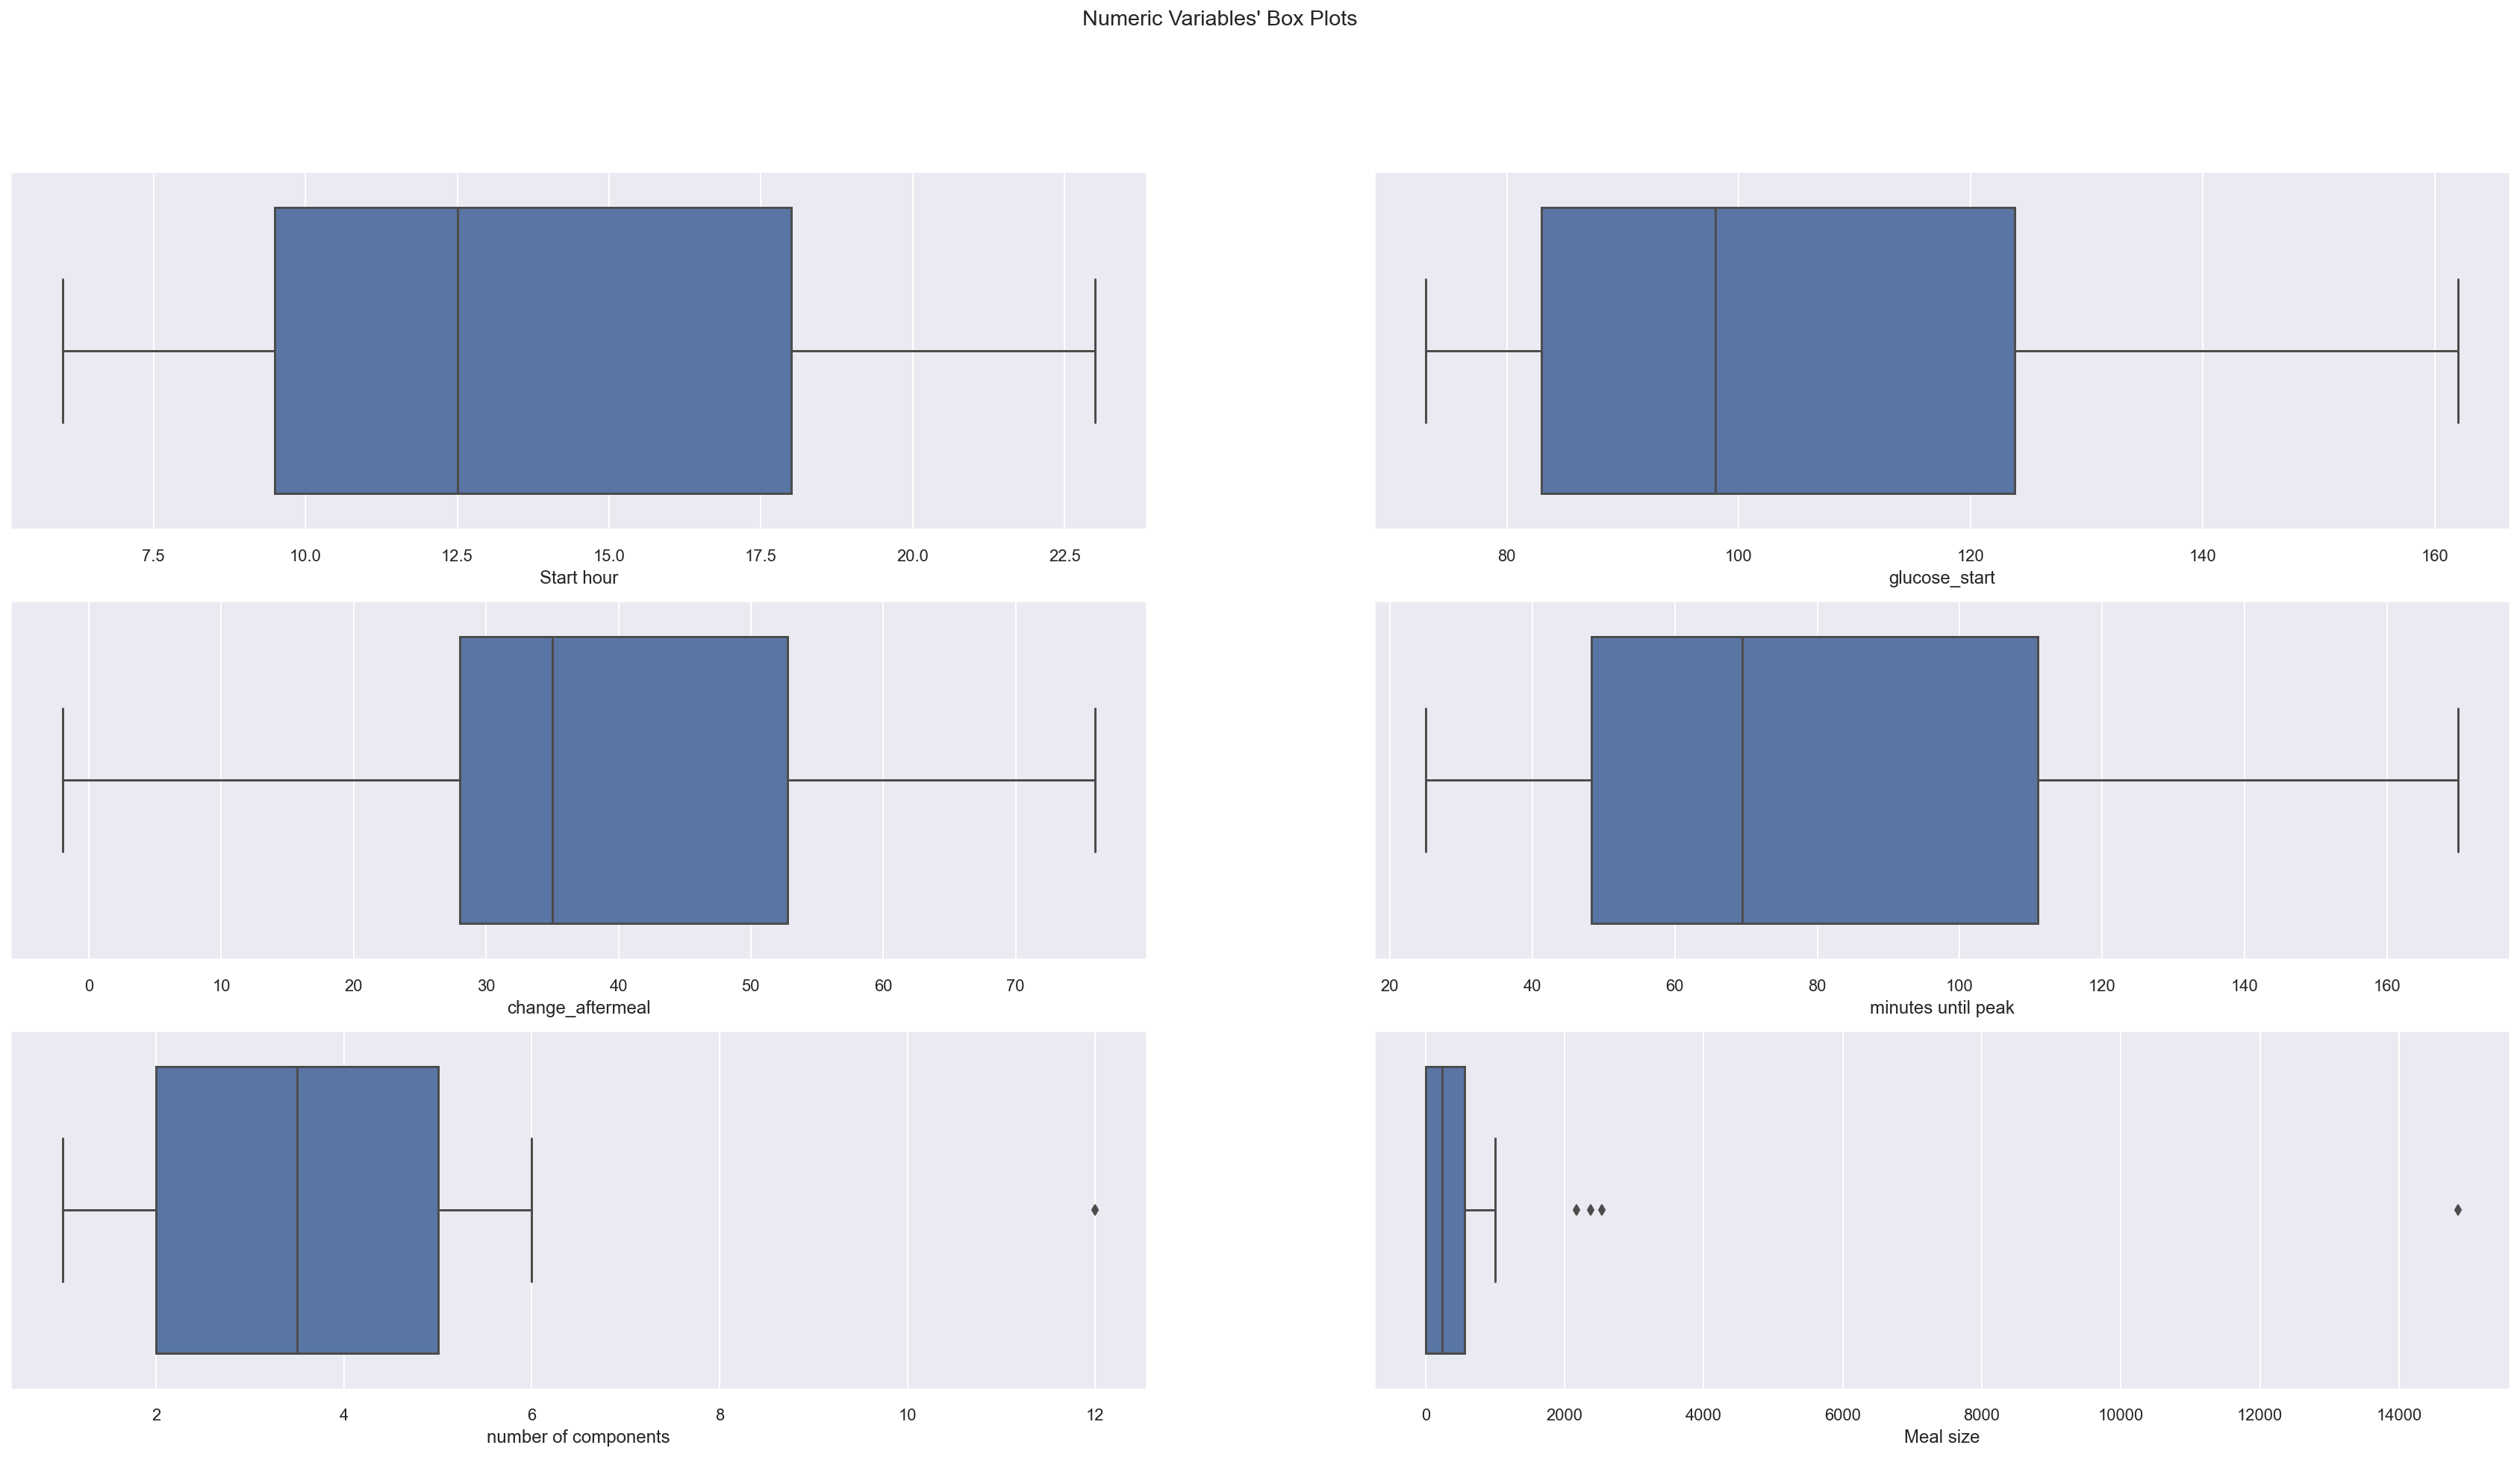

In [270]:
# All Numeric Variables' Box Plots in one figure
sns.set()

# Prepare figure. Create individual axes where each box plot will be placed
fig, axes = plt.subplots(3, ceil(len(metric_features) / 3), figsize=(30, 15))

# Plot data
# Iterate across axes objects and associate each box plot:
for ax, feat in zip(axes.flatten(), metric_features):
    sns.boxplot(x=df_clustering[feat], ax=ax)
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Box Plots"
plt.suptitle(title)
plt.subplots_adjust(wspace=0.2)

plt.show()

- overall the distribution of the variables does not show major probelms or unexpected values
- potential outlier on meal start (probably data cleaning issue - to fix before running the clustering algorithms)

In [271]:
#Noticed meal size it had an extra zero on line 19, so fixing it
df_clustering['Meal size'] = df_clustering['Meal size'].replace([14850.0], 1485)
df_clustering['Meal size'] = df_clustering['Meal size'].astype(int)

df_clustering

,Start hour,record_type,glucose_start,change_aftermeal,minutes until peak,number of components,Meal size
0,8,BREAKFAST,80.0,29.0,25.0,5,2533
1,12,LUNCH,83.0,38.0,59.0,4,277
2,16,SNACK,73.0,29.0,42.0,2,0
3,19,DINNER,73.0,28.0,111.0,12,313
4,8,BREAKFAST,78.0,30.0,36.0,3,335
5,12,LUNCH,83.0,33.0,67.0,3,262
6,19,DINNER,82.0,35.0,39.0,6,305
7,8,BREAKFAST,81.0,28.0,47.0,2,130
8,12,LUNCH,76.0,35.0,66.0,2,3
9,15,SNACK,87.0,5.0,63.0,4,52


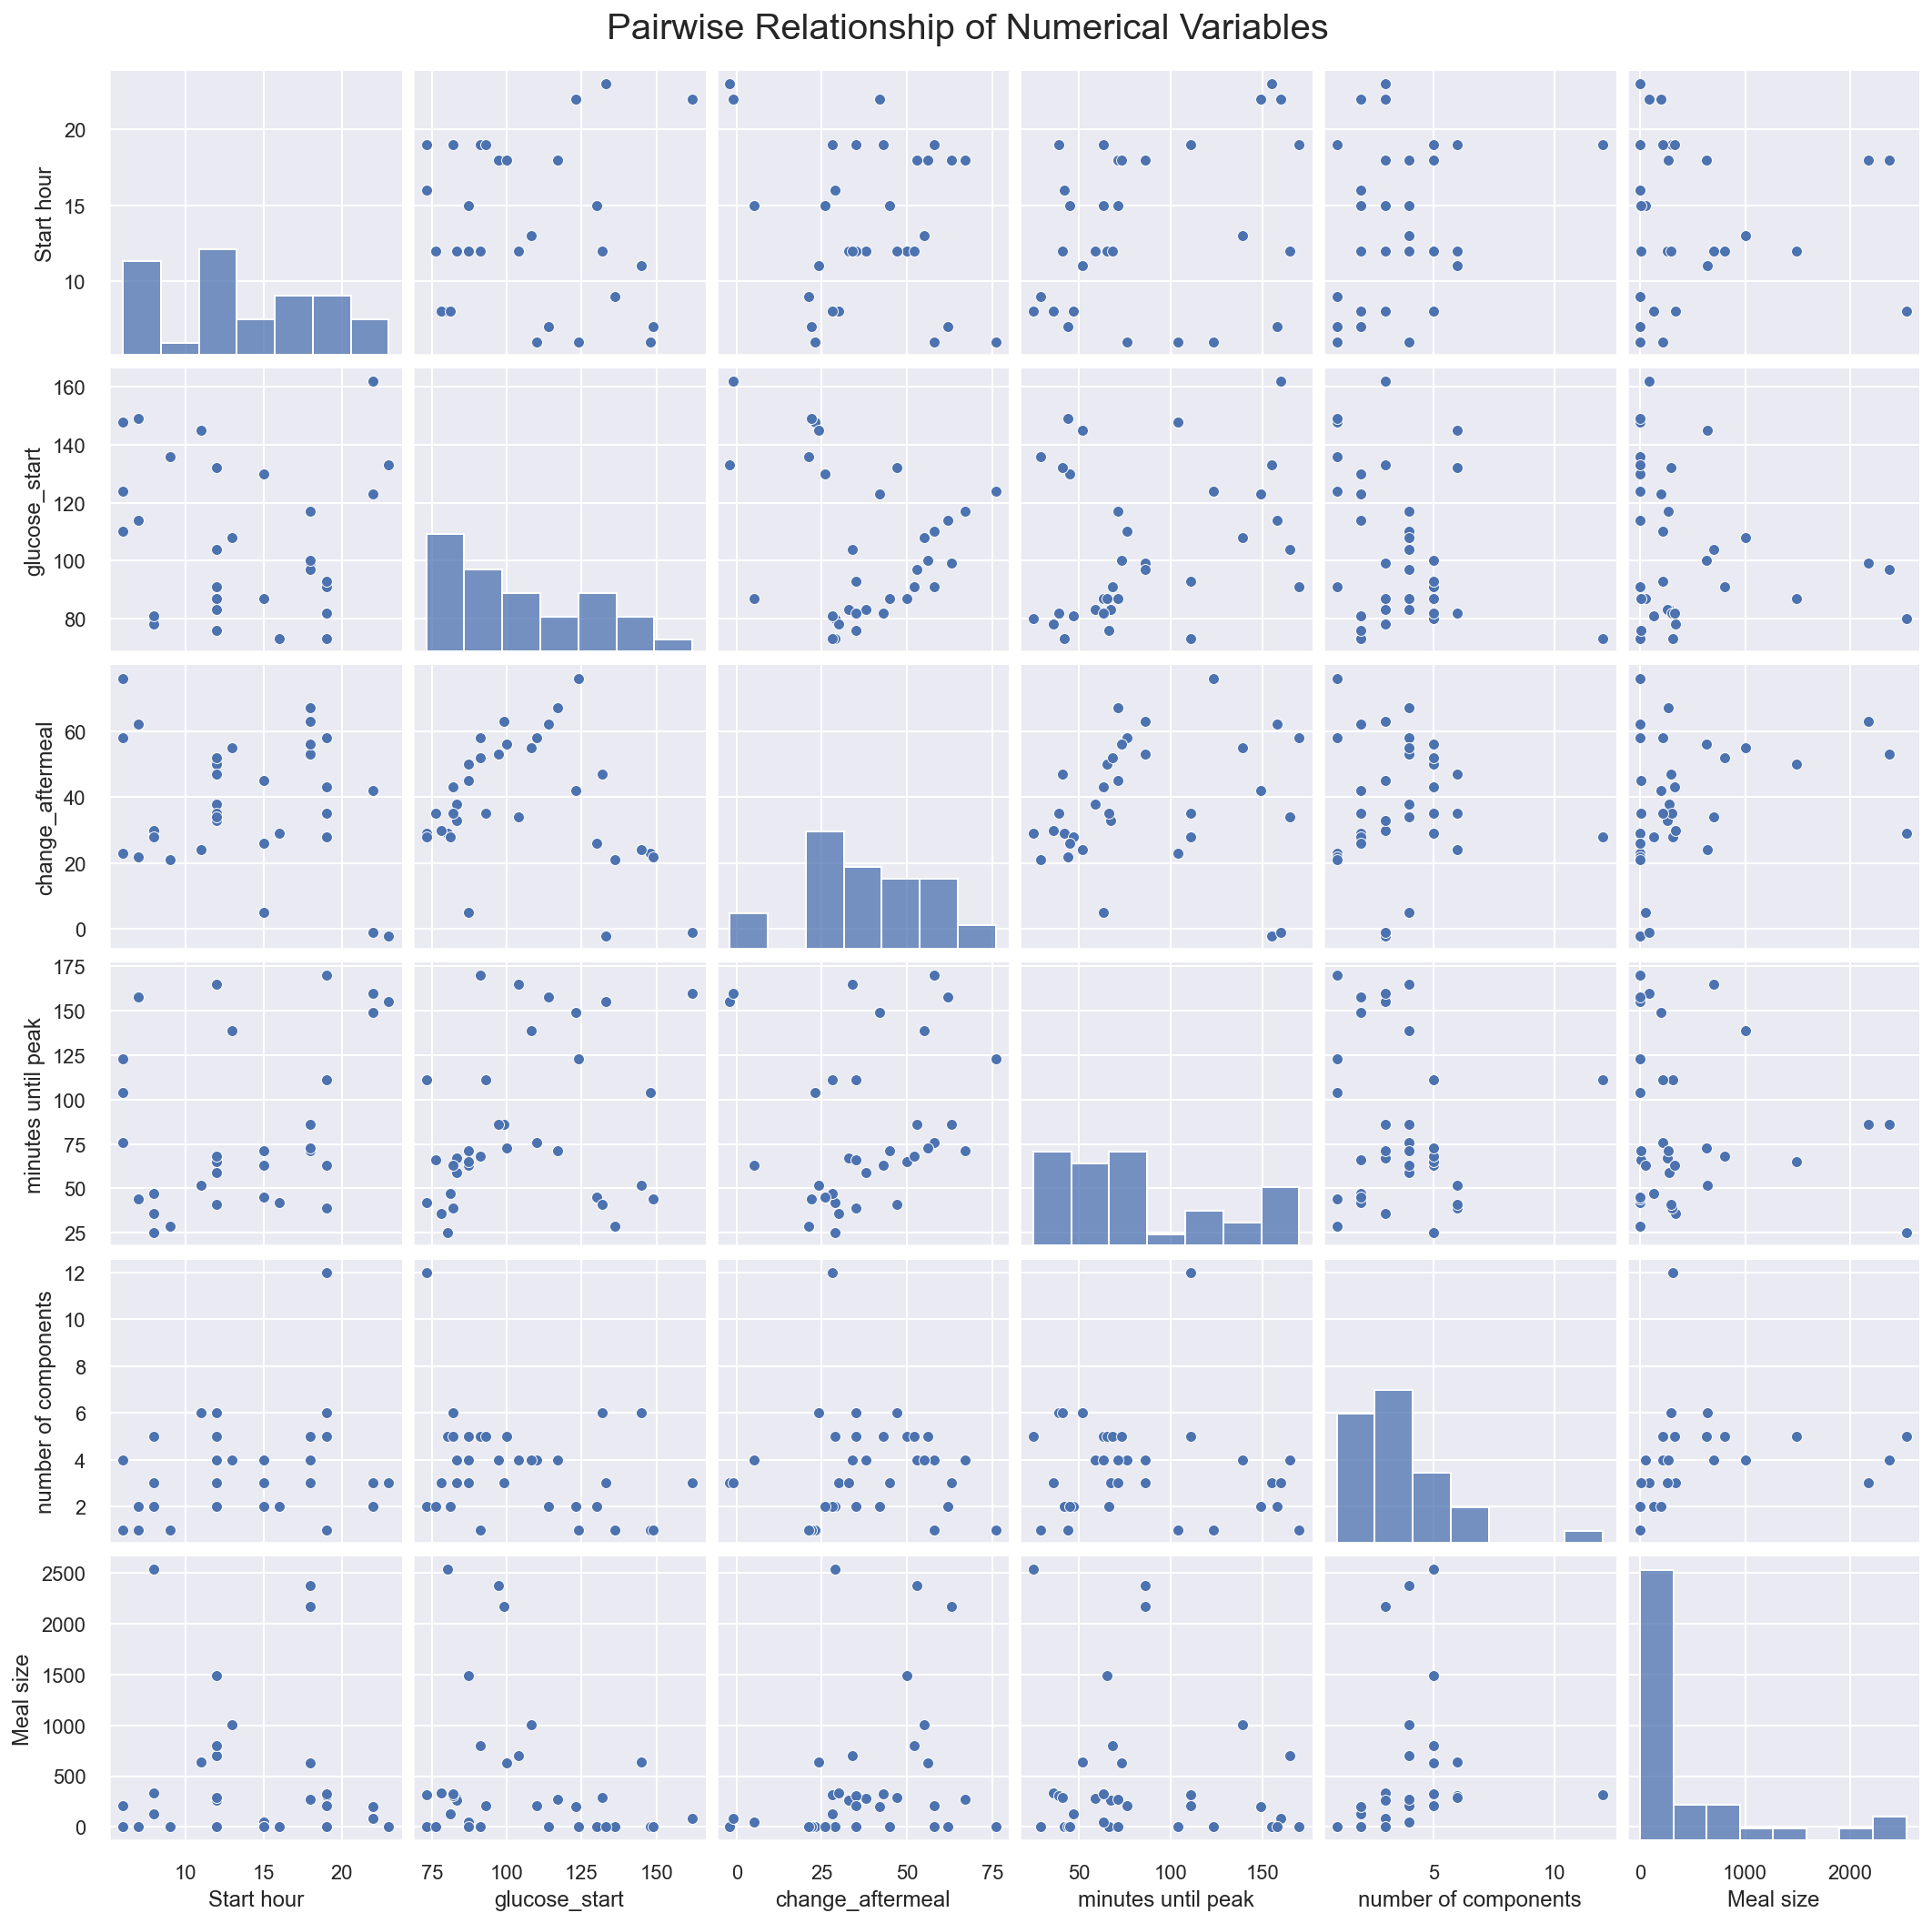

In [272]:
# Pairwise Relationship of Numerical Variables
sns.set()

# Setting pairplot
sns.pairplot(data=df_clustering[metric_features], diag_kind="hist")

# Layout
plt.subplots_adjust(top=0.95)
plt.suptitle("Pairwise Relationship of Numerical Variables", fontsize=20)

plt.show()

- From here we can have an idea of the relationship between variables
- For example, the glucose level at the start seems to be positively correlated with the minutes it takes for glucose to peak while it appears to be negatively correlated with the start hour.

interval columns not set, guessing: ['Start hour', 'glucose_start', 'change_aftermeal', 'minutes until peak', 'number of components', 'Meal size']


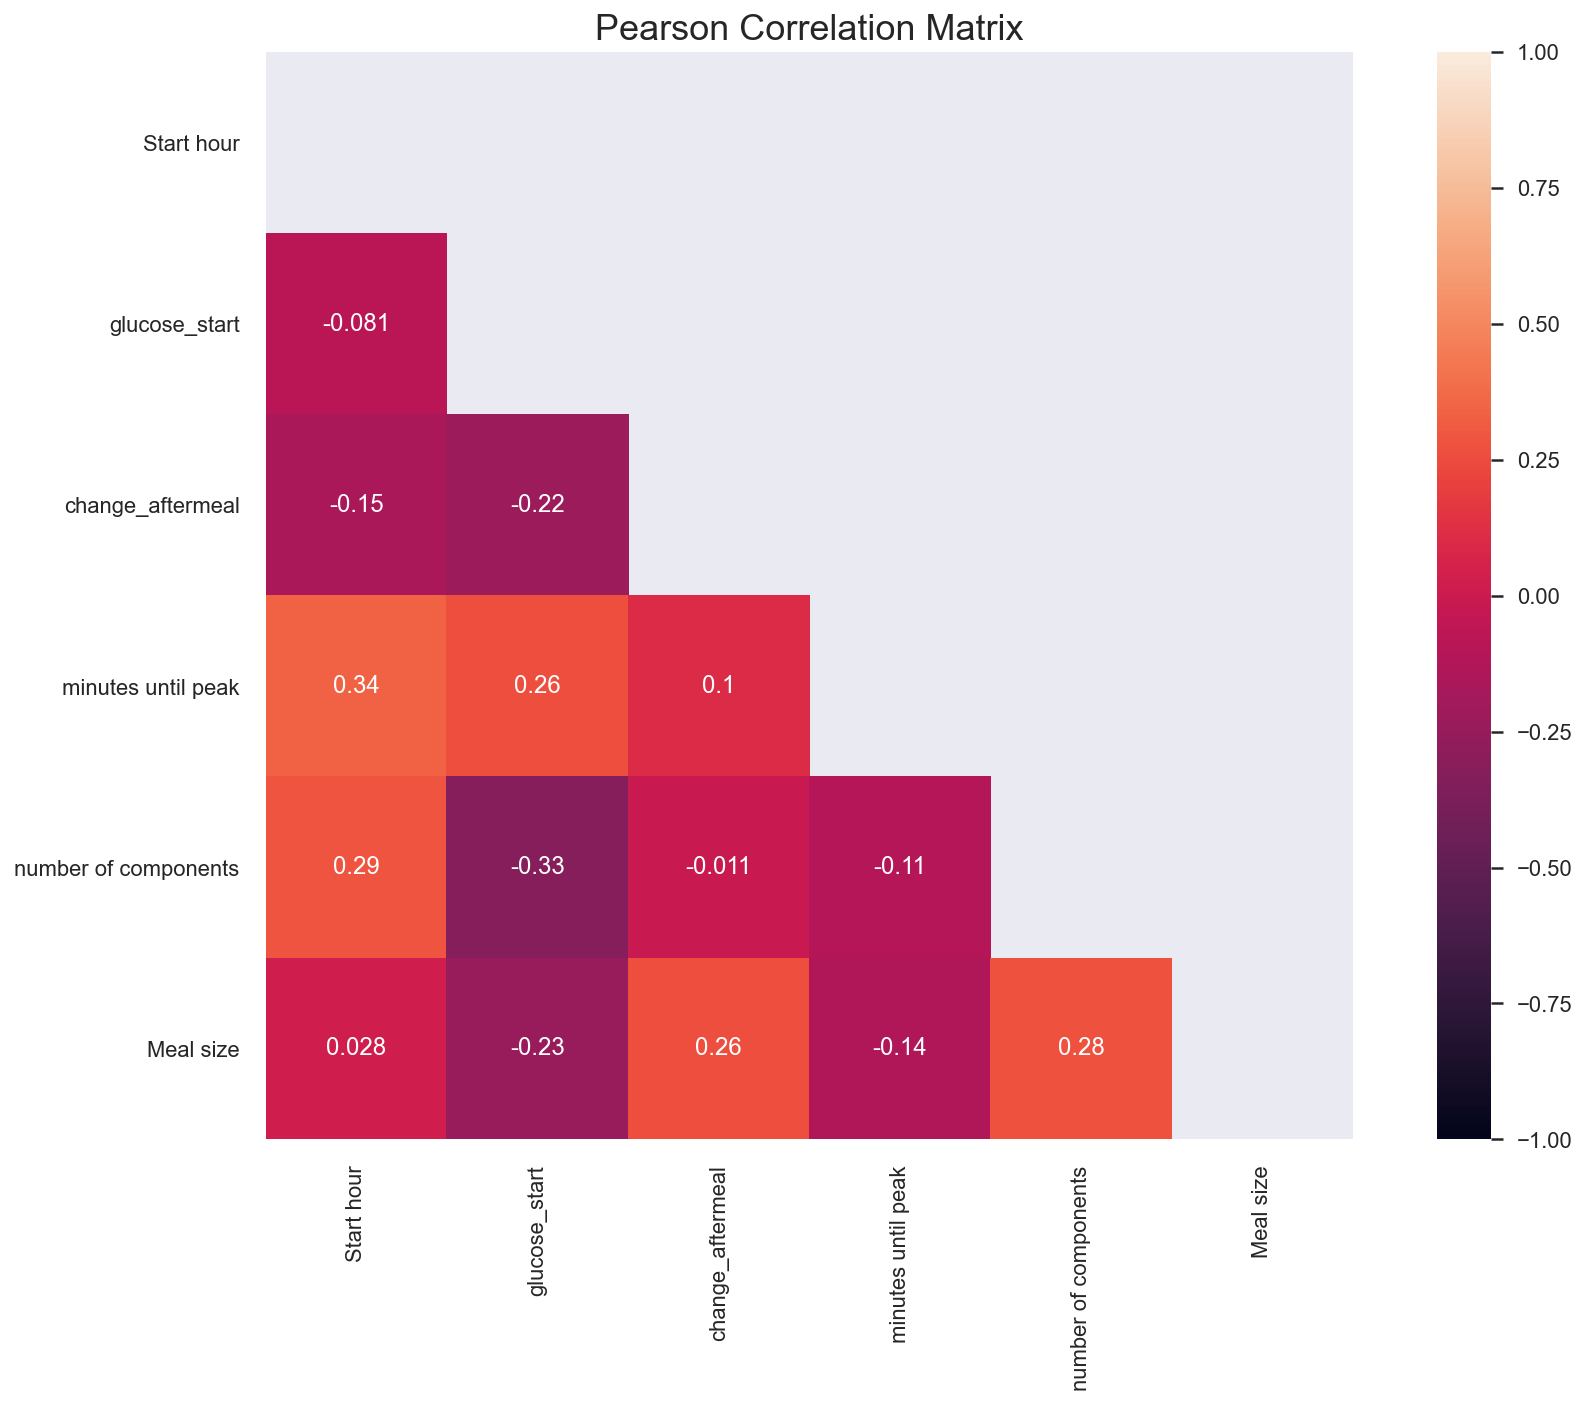

In [273]:
phik_matrix = df_clustering[metric_features].phik_matrix()
fig, axes = plt.subplots(1, 1, figsize=(15, 10))

mask = np.zeros_like(phik_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
  ax = sns.heatmap(df_clustering[metric_features].corr(),vmin=-1, vmax=1, square=True, annot=True, mask=mask)

plt.title('Pearson Correlation Matrix', fontsize=18)
plt.show()

- Pearson correlation coefficients display similar insights (but visually in this case we have less information, compared to the pairplots)

##### Scaling the data so that the clustering is not affected by the different scales in which each variable is measured

In [274]:
#Applying a StandardScaler (could haqve been a minmax or robust scaler)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
metric_features_scaled = scaler.fit_transform(df_clustering[metric_features])
data_scaled = pd.DataFrame(metric_features_scaled, 
                           columns=df_clustering[metric_features].columns)
data_scaled.head()

,Start hour,glucose_start,change_aftermeal,minutes until peak,number of components,Meal size
0,-1.143484,-0.988169,-0.501705,-1.360761,0.653724,3.062436
1,-0.350046,-0.867891,-0.011220,-0.577765,0.180817,-0.269258
2,0.443392,-1.268819,-0.501705,-0.969263,-0.764996,-0.678336
3,1.038470,-1.268819,-0.556203,0.619759,3.964073,-0.216093
4,-1.143484,-1.068355,-0.447207,-1.107439,-0.292090,-0.183603


##### Principal Component analysis (this is helpful to understand if the variability can the captured while reducing dimensionality - e.g. using less variables)

In [275]:
# Principal component analysis
df_pca = data_scaled[metric_features].copy(0)

pca = PCA()
pca_feat = pca.fit_transform(df_pca)

# Output PCA table
pca_table =pd.DataFrame(
    {"Eigenvalue": pca.explained_variance_,
     "Difference": np.insert(np.diff(pca.explained_variance_), 0, 0),
     "Proportion": pca.explained_variance_ratio_,
     "Cumulative": np.cumsum(pca.explained_variance_ratio_)},
    index=range(1, pca.n_components_ + 1)
)
pca_table

,Eigenvalue,Difference,Proportion,Cumulative
1,1.807146,0.000000,0.292332,0.292332
2,1.446926,-0.360220,0.234062,0.526394
3,1.183028,-0.263898,0.191372,0.717766
4,0.776595,-0.406433,0.125626,0.843392
5,0.564684,-0.211911,0.091346,0.934738
6,0.403440,-0.161243,0.065262,1.000000


The minimum number of PCA to obtain at least 0.8 variance explained is:  3


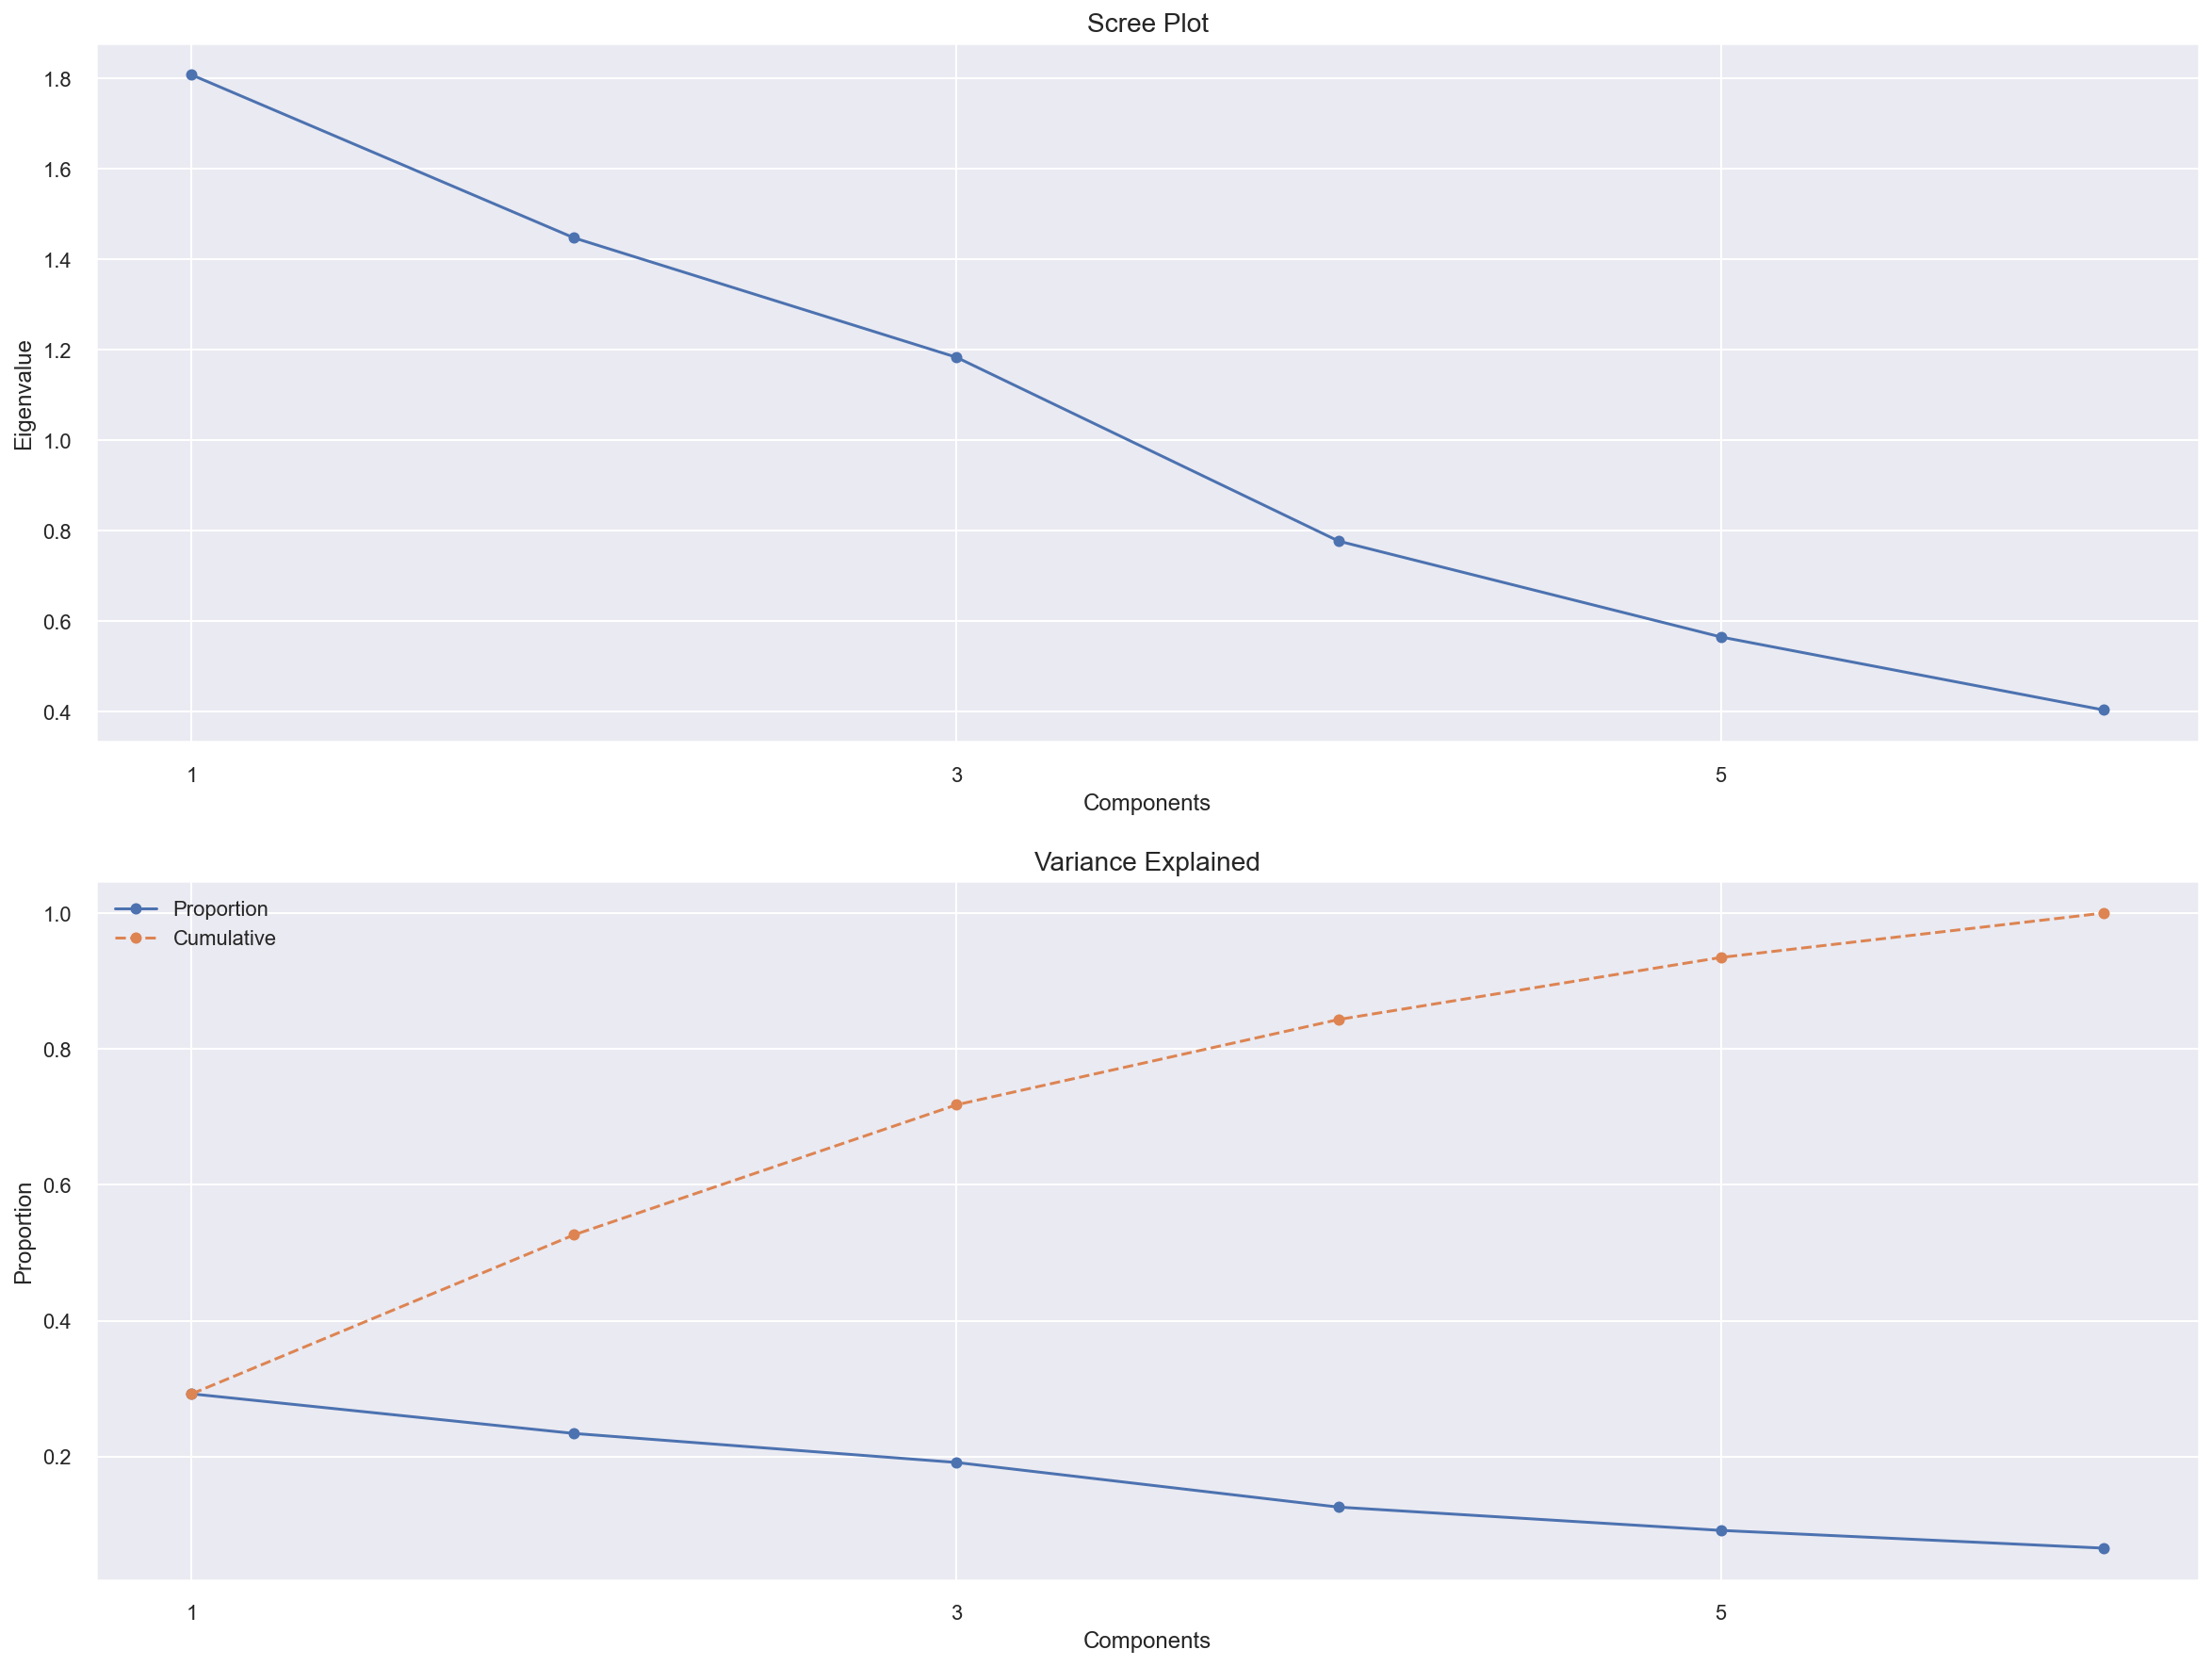

In [276]:
#figure and axes
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 15))

# draw plots
ax1.plot(pca.explained_variance_, marker=".", markersize=12)
ax2.plot(pca.explained_variance_ratio_, marker=".", markersize=12, label="Proportion")
ax2.plot(np.cumsum(pca.explained_variance_ratio_), marker=".", markersize=12, linestyle="--", label="Cumulative")

# customizations
ax2.legend()
ax1.set_title("Scree Plot", fontsize=14)
ax2.set_title("Variance Explained", fontsize=14)
ax1.set_ylabel("Eigenvalue")
ax2.set_ylabel("Proportion")
ax1.set_xlabel("Components")
ax2.set_xlabel("Components")
ax1.set_xticks(range(0, pca.n_components_, 2))
ax1.set_xticklabels(range(1, pca.n_components_ + 1, 2))
ax2.set_xticks(range(0, pca.n_components_, 2))
ax2.set_xticklabels(range(1, pca.n_components_ + 1, 2))

print('The minimum number of PCA to obtain at least 0.8 variance explained is: ',len(pca_table[pca_table["Cumulative"]<0.8]))
plt.show()

In [277]:
# Perform PCA again with the number of principal components you want to retain
pca = PCA(n_components=3)
pca_feat = pca.fit_transform(df_pca)
pca_feat_names = [f"PC{i}" for i in range(pca.n_components_)]
pca_df = pd.DataFrame(pca_feat, index=df_pca.index, columns=pca_feat_names)  
df_pca = pd.concat([df_pca, pca_df], axis=1)
df_pca.head()

,Start hour,glucose_start,change_aftermeal,minutes until peak,number of components,Meal size,PC0,PC1,PC2
0,-1.143484,-0.988169,-0.501705,-1.360761,0.653724,3.062436,-2.602096,-1.381500,-0.594537
1,-0.350046,-0.867891,-0.011220,-0.577765,0.180817,-0.269258,-0.574104,-0.518765,-0.476289
2,0.443392,-1.268819,-0.501705,-0.969263,-0.764996,-0.678336,-0.157384,-0.357187,-0.962005
3,1.038470,-1.268819,-0.556203,0.619759,3.964073,-0.216093,-2.351046,2.555253,-1.349772
4,-1.143484,-1.068355,-0.447207,-1.107439,-0.292090,-0.183603,-0.454033,-1.480955,-0.921602


In [278]:
def _color_red_or_green(val):
    if val < -0.6:
        color = 'background-color: red'
    elif val > 0.6:
        color = 'background-color: green'
    else:
        color = ''
    return color

# Interpreting each Principal Component
loadings = df_pca[df_pca.columns].corr().loc[df_pca.columns, pca_feat_names]
loadings.style.applymap(_color_red_or_green)

,PC0,PC1,PC2
Start hour,-0.112856,0.891993,-0.049121
glucose_start,0.748254,0.037033,0.074729
change_aftermeal,-0.372493,-0.230896,0.812132
minutes until peak,0.375763,0.619532,0.577745
number of components,-0.664397,0.410645,-0.290849
Meal size,-0.678234,-0.039786,0.249591
PC0,1.000000,0.000000,0.000000
PC1,0.000000,1.000000,0.000000
PC2,0.000000,0.000000,1.000000


We could capture around 80% of the variability in the data using 2 principal components instead of teh original 6 variables:
- PC0 correlates positively with glucose start and negatively with the number of components in the mean and meal size
- PC1 is positively related with the start hour and the time for glucose to peak
- PC2 is highly correlated with the change in glucose after the meal

### The clustering test will start here

###### These functions had been previously prepared in a data mining project (will be helpful for visualizing and running clustering algorithms)

In [279]:
def kelbowplots(clus_estim, data):
    """
    This function produces the k-elbow plot for a given clustering estimator according to 3 different clustering quality measures: "Distortion", "Silhouette" and "Calinski Harabasz".
    Distortion - representing the sum of distance between observations within each cluster - lower values indicate better clusters as points in the same cluster are closer together
    Avg Silhouette - ratio between (a) difference between avg distance to observations in closest cluster and to same cluster and (b) max between both values - the highest the better as it indicates the observations are closer to the ones in their own cluster when compared to the closest
    Calinski Harabasz - ratio between sum of distance between and within clusters - the lowest the better as it indicates that distance between clusters is greater than within
    """
    sns.set()
    fig, axes = plt.subplots(1, 3, figsize=(20,7))

    # Plot the data
    metrics = ["distortion", "silhouette", "calinski_harabasz"]
    ylabels = ["Distortion measure", "Silhouette measure", "Calinski Harabasz measure"]
    titles = ["Distortion measure plot", "Silhouette measure plot", "Calinski Harabasz measure plot"]
    for ax, m, yl, tl in zip(axes.flatten(), metrics, ylabels, titles):
        # KElbowVisualizer produces the elbow plot for several quality measures
        KElbowVisualizer(clus_estim, metric=m, timings=False, locate_elbow=False, ax=ax).fit(data)
        #ax.invert_xaxis()
        ax.set_ylabel(yl, fontsize=13)
        ax.set_xlabel("Number of clusters", fontsize=13)
        ax.set_title(tl, fontsize=13)

    # Set figure
    plt.suptitle("K-Elbow Plots", fontsize=23)

    plt.show()

In [280]:
def get_r2_hc(df, link, max_nclus, min_nclus=1, dist="euclidean"):
    """
    This function calculates the R2 for a set of cluster solutions given by the application of a hierarchical method.
    The R2 is a measure of the homogenity of a cluster solution. It is based on the fact that the Sum of squares (SSt) of all the data
    can be decomposed into the sum of SS within clusters (SSw) and SS between clusters (SSb): SSt = SSw + SSb. The R2 is the ratio between
    SSb and SSt: R2 = SSb/SSt. The higher the R2 the better the solution since SSw will be close to 0 which indicated perfect homogeneous
    clusters.
    """
    def get_ss(matrix):
        mc = matrix - matrix.mean(axis=0)
        return (mc.T@mc).trace() #return sum of squares of matrix
    
    matrix = df.values
    ncols = matrix.shape[1]
    sst = get_ss(matrix) #get total sum of squares
    
    r2 = np.array([]) #where we will store the R2 metrics
    
    for i in range(min_nclus, max_nclus+1):
        Hclustering = AgglomerativeClustering(n_clusters=i, affinity=dist, linkage=link)
        hclabels = Hclustering.fit_predict(matrix) #get cluster labels
        concat = np.concatenate((matrix, np.expand_dims(hclabels,1)), axis=1)
        ssw = np.array([get_ss(concat[concat[:,ncols]==j, :ncols]) for j in range(i)]).sum() #calculate ssw for a given cluster solution
        r2 = np.append(r2, (sst-ssw)/sst) #save the R2 of the given cluster solution
        
    return r2

In [281]:
def silhouette_analysis(df, estimator, shape, figsize, max_nclus, min_nclus=2, dist="euclidean"):
    """
    This function calculates the silhouette coefficient for each observation according to a clustering solution and then builds the 
    Silhouette plots for a given range of cluster solutions. This is useful to find out the most appropriate number of clusters.
    Avg Silhouette - ratio between (a) difference between avg distance to observations in closest cluster and to same cluster and (b) max between both values - the highest the better as it indicates the observations are closer to the ones in their own cluster when compared to the closest
    """
    range_n_clusters = list(range(min_nclus, max_nclus+1))
    
    sns.set()
    fig, axes = plt.subplots(nrows=shape[0], ncols=shape[1], figsize=figsize)
    if len(range_n_clusters)==1: # in case we want to seed the silhouette for just one cluster solution
        forax = [axes]
    else:
        forax = axes.flatten()
    for ax, n_clusters in zip(forax, range_n_clusters):
        
        # Get parameter that defines number of clusters
        if "n_clusters" in estimator.get_params():
            param = "n_clusters"
        elif "n_components" in estimator.get_params():
            param = "n_components"
        else:
            print("Estimator has no parameter to define number of clusters")
            return None
        
        # Get the cluster labels by applying a given clustering algorithm
        clustering = estimator.set_params(**{param:n_clusters})
        labels = clustering.fit_predict(df)
        
        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed clusters
        silhouette_avg = silhouette_score(df, labels, metric=dist)
        
        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(df, labels, metric=dist)
        
        # The silhouette coefficient can range from -1, 1
        ax.set_xlim([sample_silhouette_values.min()-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette plots of individual clusters, to demarcate them clearly.
        ax.set_ylim([0, df.shape[0] + (n_clusters + 1) * 10]) 
        
        y_lower = 10 # initialize y_lower
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples
        
        ax.set_title("{} Clusters".format(n_clusters), fontsize=13)
        ax.set_xlabel("Silhouette Coefficients")
        ax.set_ylabel("Cluster Labels")
        ax.set_yticks([])  # Clear the yaxis labels / ticks
        ax.axvline(x=silhouette_avg, color="red", linestyle="--", label="Average Silhouette") # The vertical line for average silhouette score of all the values
        handles, _ = ax.get_legend_handles_labels()
        ax.legend(handles, ["Average Silhouette = {0:.2f}".format(silhouette_avg)])
    
    plt.subplots_adjust(hspace=0.35)
    plt.suptitle(("Clustering Silhouette Plots"), fontsize=23, fontweight='bold')
    plt.show()

In [282]:
def cluster_profiles(df, label_columns, figsize, compar_titles=None):
    """
    Pass df with labels columns of one or multiple clustering labels. 
    Then specify this label columns to perform the cluster profile according to them.
    """
    if compar_titles == None:
        compar_titles = [""]*len(label_columns)
        
    sns.set()
    fig, axes = plt.subplots(nrows=len(label_columns), ncols=2, figsize=figsize, squeeze=False)
    for ax, label, titl in zip(axes, label_columns, compar_titles):
        # Filtering df
        drop_cols = [i for i in label_columns if i!=label]
        dfax = df.drop(drop_cols, axis=1)
        
        # Getting the cluster centroids and counts
        centroids = dfax.groupby(by=label, as_index=False).mean()
        counts = dfax.groupby(by=label, as_index=False).count().iloc[:,[0,1]]
        counts.columns = [label, "counts"]
        
        # Setting Data
        pd.plotting.parallel_coordinates(centroids, label, color=sns.color_palette(), ax=ax[0])
        sns.barplot(x=label, y="counts", data=counts, ax=ax[1])

        #Setting Layout
        handles, _ = ax[0].get_legend_handles_labels()
        cluster_labels = ["Cluster {}".format(i) for i in range(len(handles))]
        ax[0].annotate(s=titl, xy=(0.95,1.1), xycoords='axes fraction', fontsize=13, fontweight = 'heavy') 
        ax[0].legend(handles, cluster_labels) # Adaptable to number of clusters
        ax[0].axhline(color="black", linestyle="--")
        ax[0].set_title("Cluster Means - {} Clusters".format(len(handles)), fontsize=13)
        ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=-20)
        ax[1].set_xticklabels(cluster_labels)
        ax[1].set_xlabel("")
        ax[1].set_ylabel("Absolute Frequency")
        ax[1].set_title("Cluster Sizes - {} Clusters".format(len(handles)), fontsize=13)
    
    plt.subplots_adjust(hspace=0.4, top=0.90)
    plt.suptitle("Cluster Simple Profilling", fontsize=23)
    plt.show()

In [283]:
def comp_gmm_models(df, max_nclus, min_nclus=2):
    """
    This function produces a bar plot for each quality criteria (AIC, BIC) to asses what is the best gmm configuration
    """
    # Data
    n_components_range = range(min_nclus, max_nclus+1)
    cv_types = ['spherical', 'tied', 'diag', 'full'] #values of the covariance type parameter
    bic = np.empty((4, len(n_components_range)))
    aic = np.empty((4, len(n_components_range)))
    for r, cv_type in enumerate(cv_types):
        for c, n_components in enumerate(n_components_range):
            # Fit a Gaussian mixture with EM
            gmm = GaussianMixture(n_components=n_components, covariance_type=cv_type)
            gmm.fit(df)
            # Save quality measure value
            bic[r, c] = gmm.bic(df)
            aic[r, c] = gmm.aic(df)

    # Traces
    bic = pd.DataFrame(bic, columns=n_components_range, index=cv_types)
    aic = pd.DataFrame(aic, columns=n_components_range, index=cv_types)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(23,7))
    
    sns.barplot(data=bic.reset_index().melt(id_vars="index"),
                x="variable", y="value", hue="index", ax=ax1)
    
    sns.barplot(data=aic.reset_index().melt(id_vars="index"),
                x="variable", y="value", hue="index", ax=ax2)

    # Layout
    ax1.set_xlabel('Number of Components')
    ax2.set_xlabel('Number of Components')
    ax1.set_ylabel('BIC Criteria')
    ax2.set_ylabel('AIC Criteria')
    ax1.legend(title="Covariance Type")
    ax2.legend(title="Covariance Type")
    plt.suptitle('BIC and AIC Scores per Model', fontsize=23)

    plt.show()

### Clustering tests 

In [284]:
#Define data for clustering 
data_clust_test = data_scaled

#### Kmeans 

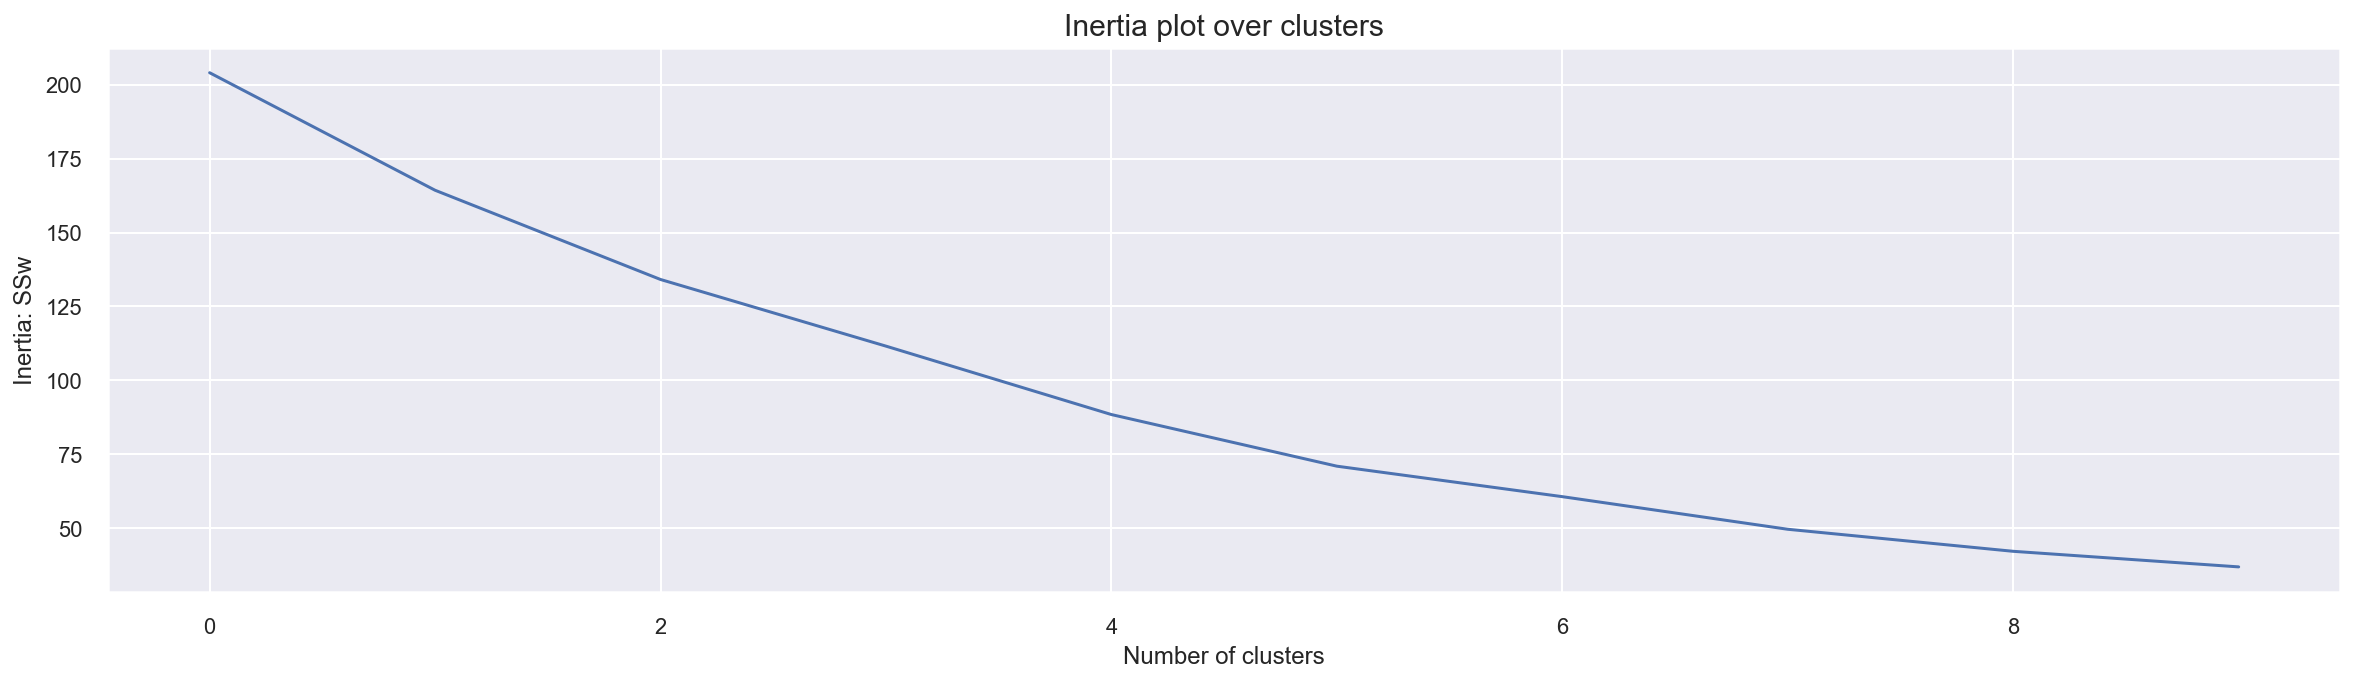

In [285]:
#Look at the optimal number of clusters

range_clusters = range(1, 11)
inertia = []

for n_clus in range_clusters:  # iterate over desired ncluster range
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=1)
    kmclust.fit(data_clust_test)
    inertia.append(kmclust.inertia_)  # save the inertia of the given cluster solution

# The inertia plot
plt.figure(figsize=(20,5))
plt.plot(inertia)
plt.ylabel("Inertia: SSw")
plt.xlabel("Number of clusters")
plt.title("Inertia plot over clusters", size=15)
plt.show()

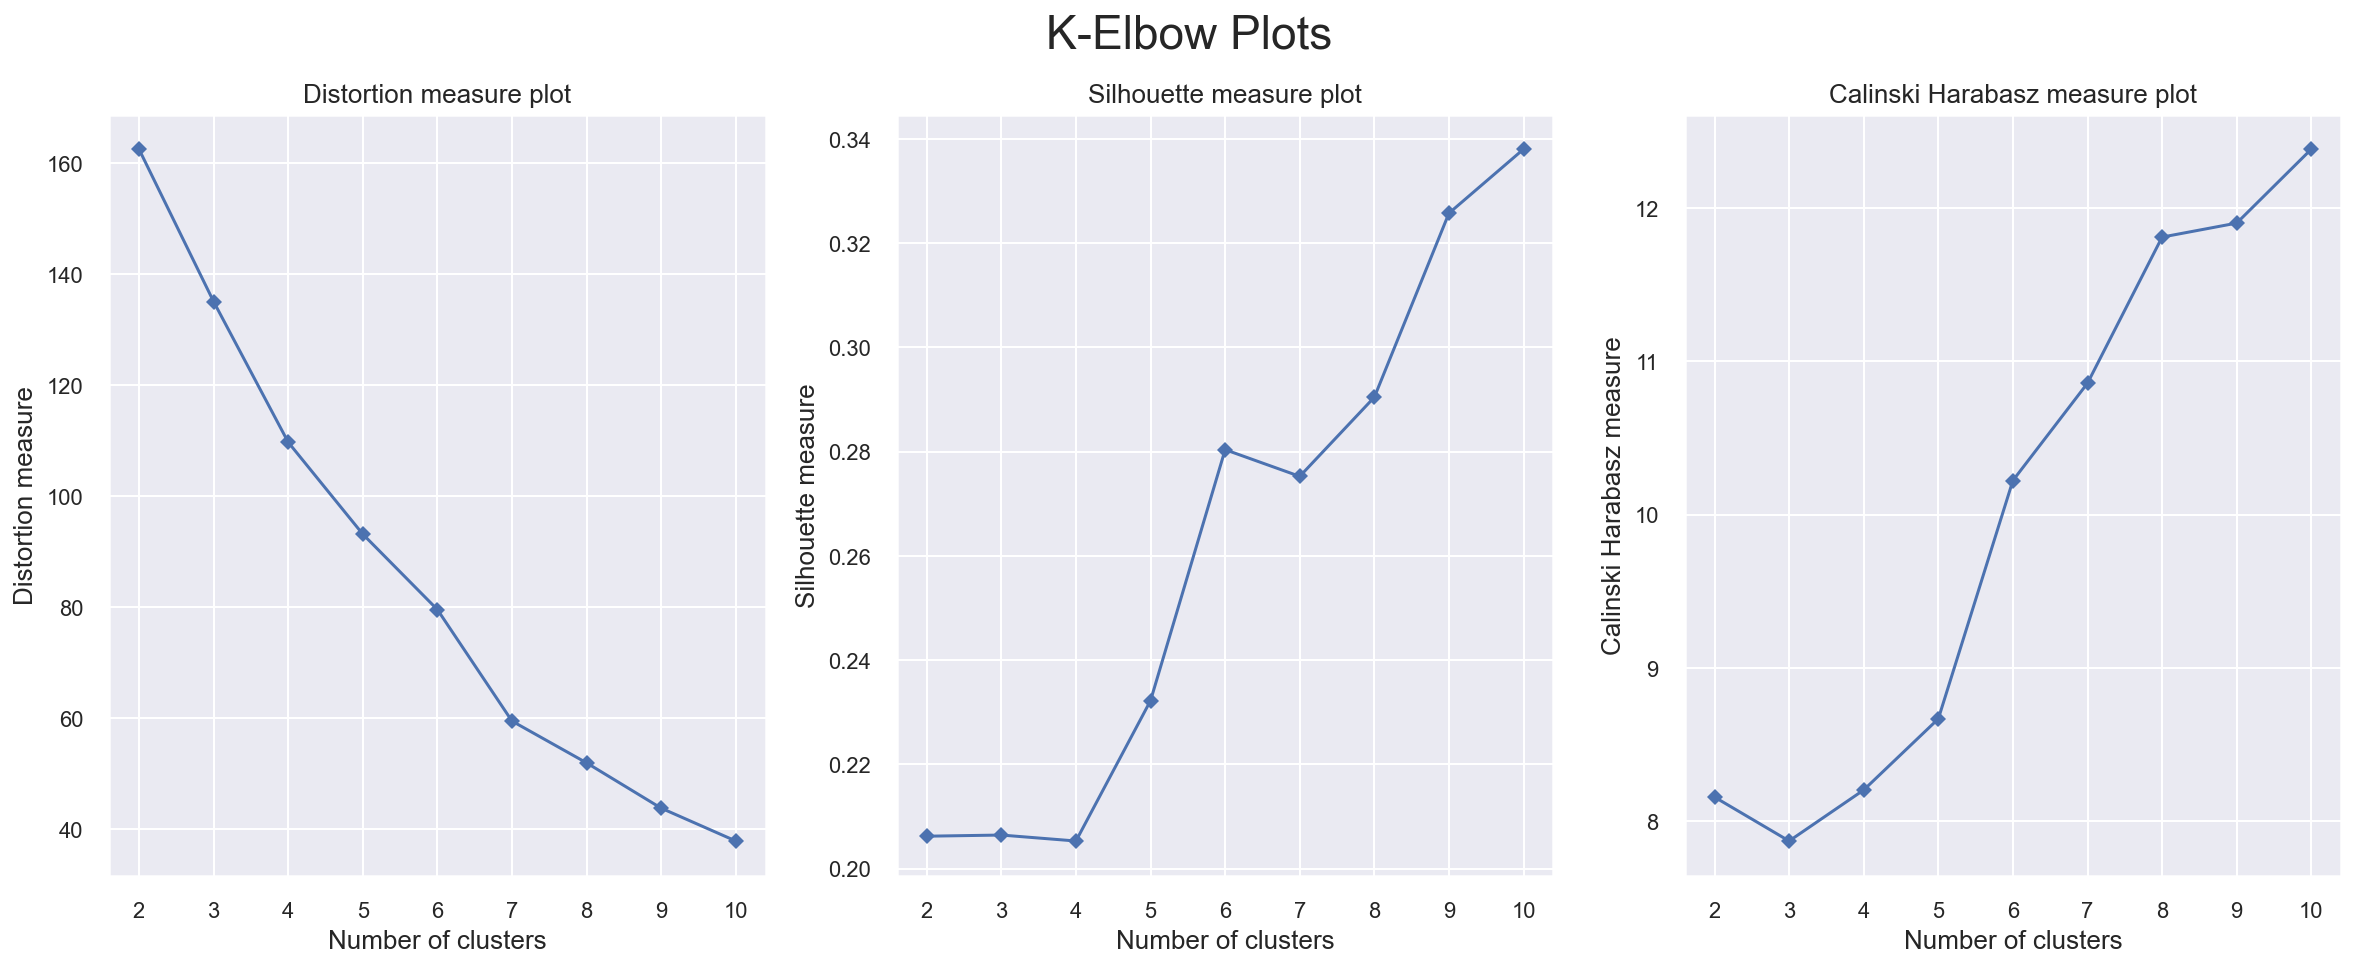

In [286]:
# K-elbow plots
kelbowplots(KMeans(), data_clust_test)

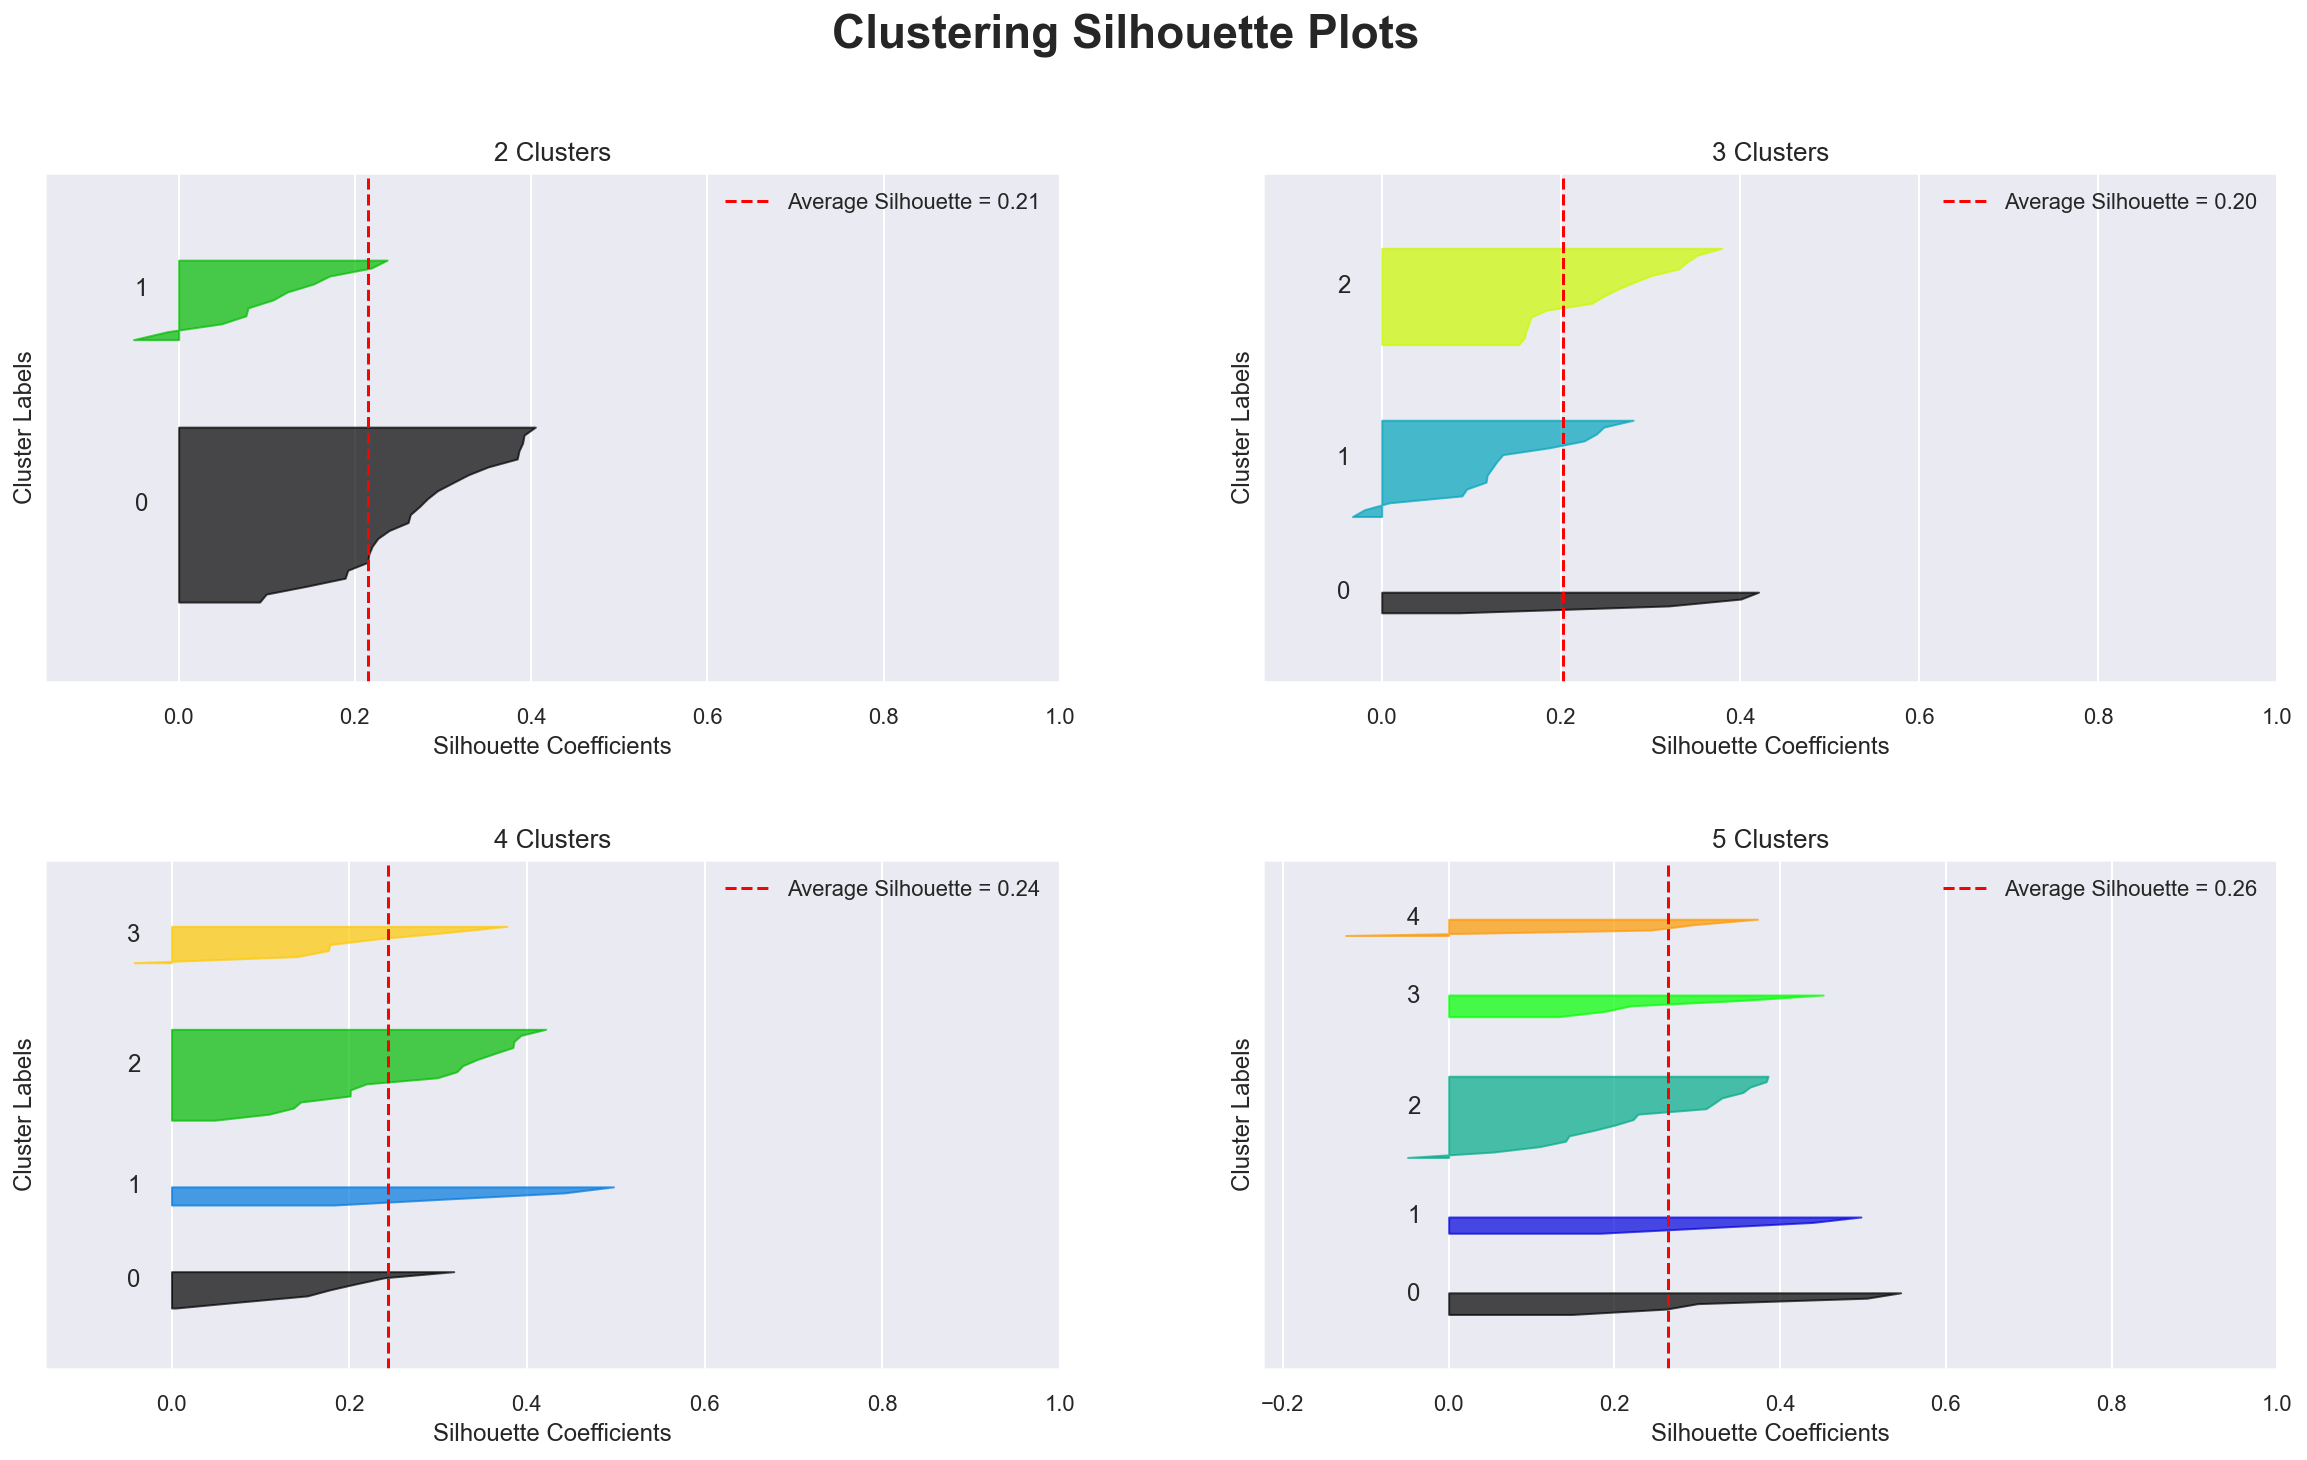

In [287]:
kmeans = KMeans(random_state=0)
silhouette_analysis(data_clust_test, kmeans, (2,2), (20,11), max_nclus=6)

- For choosing the right number of clusters, when considering the trade-off between the increase in the metrics displayed above and the complexity that more clusters adds to the interpretability of the results, a 4 or 5 cluster solution seems to work best. 

In [288]:
#Function for running K means Clustering 
def doKmeans(df, nclust):
    model = KMeans(nclust, random_state=0)
    model.fit(df)
    clust_labels = model.predict(df)
    cent = model.cluster_centers_
    return (clust_labels, cent)

In [289]:
# Performing kmeans and appending the cluster labels to a new dataframe that keeps the cluster labels
clust_labels, cent = doKmeans(data_clust_test, 5)
kmeans_data_clust_test = data_clust_test.copy()
kmeans_data_clust_test["kmeans_labels"] = clust_labels

## GMM (Gaussian Mixture Model) - takes into account the variance, which kmeans is not able to

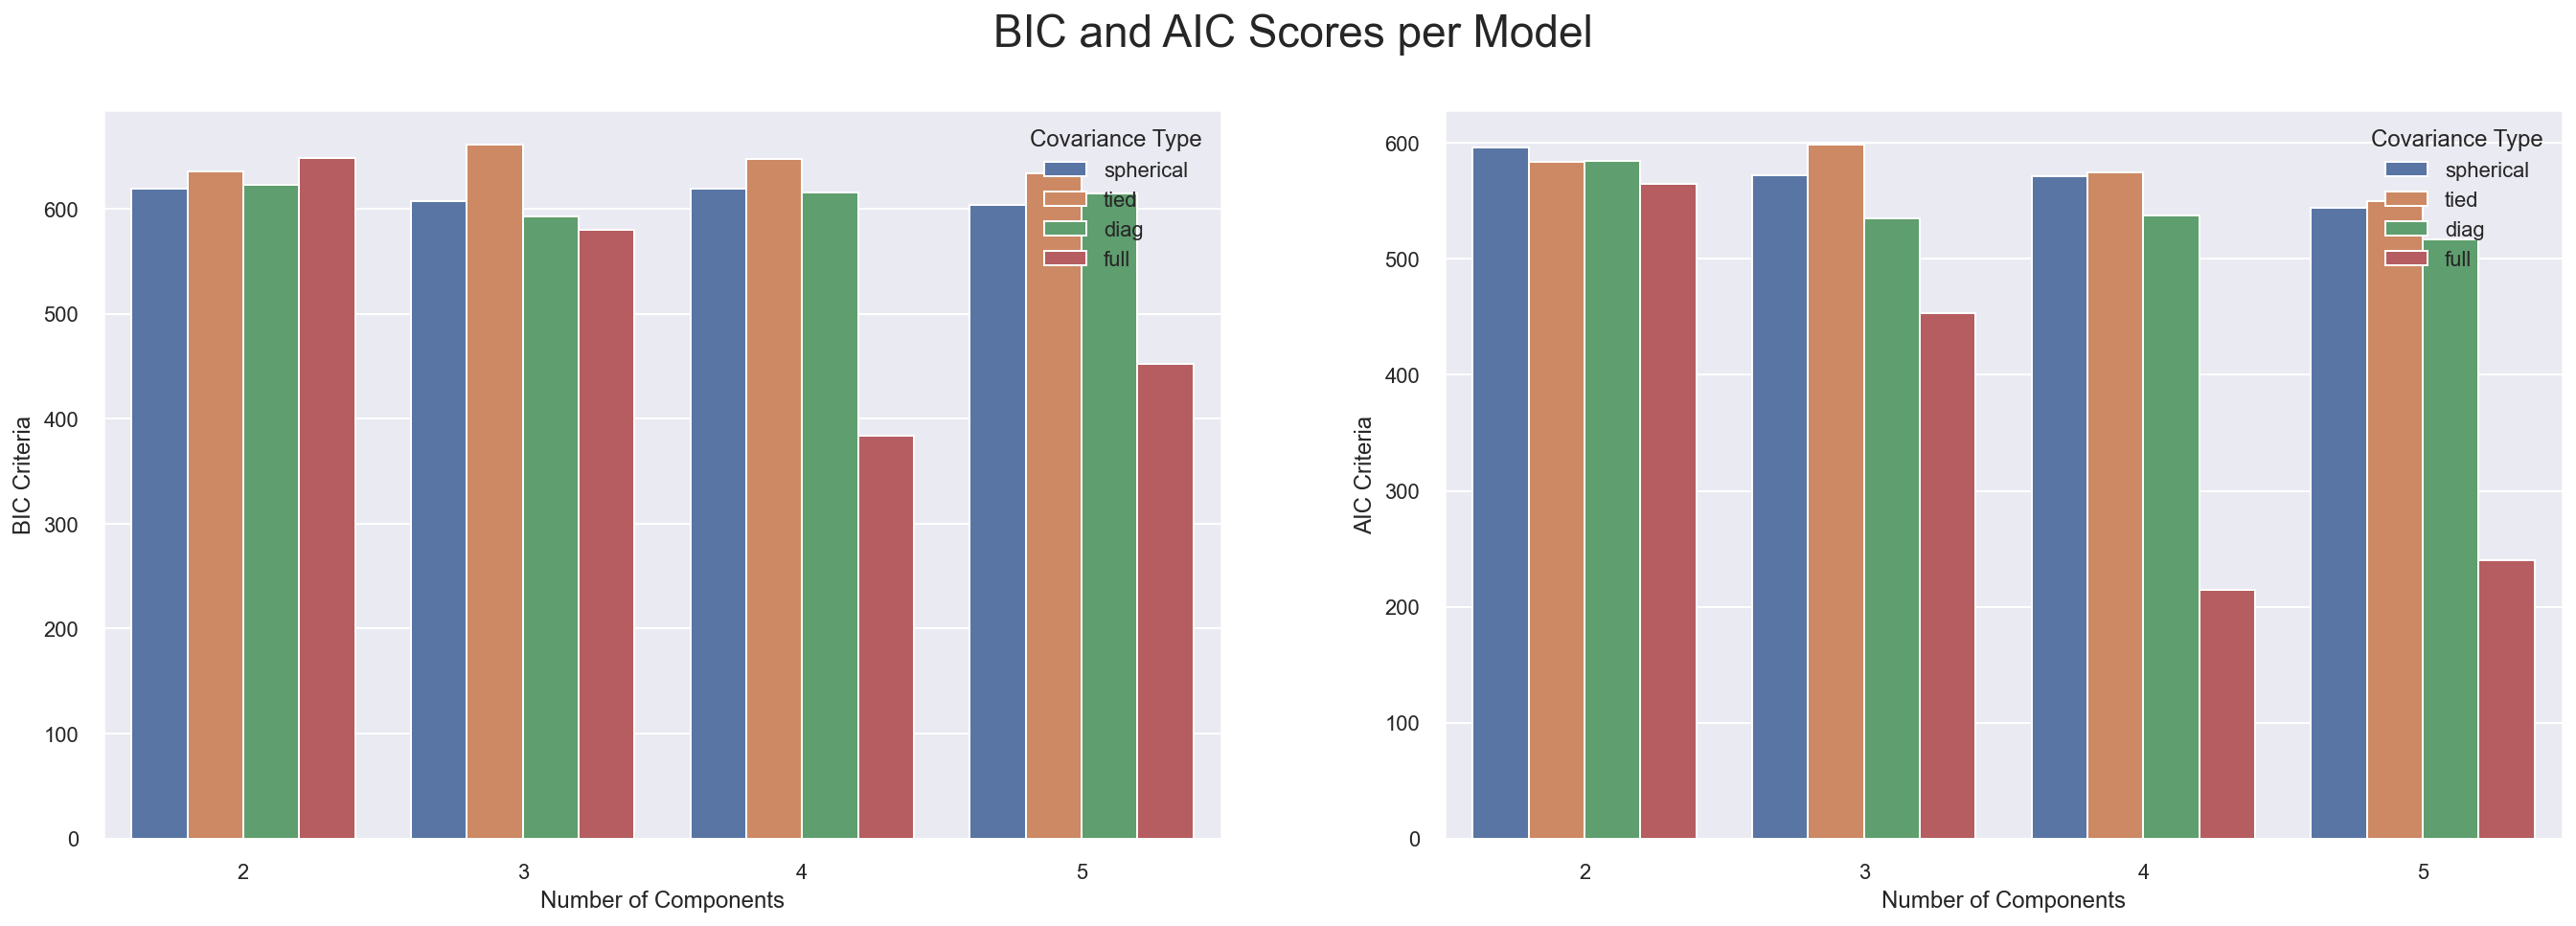

In [290]:
comp_gmm_models(data_clust_test, 5)

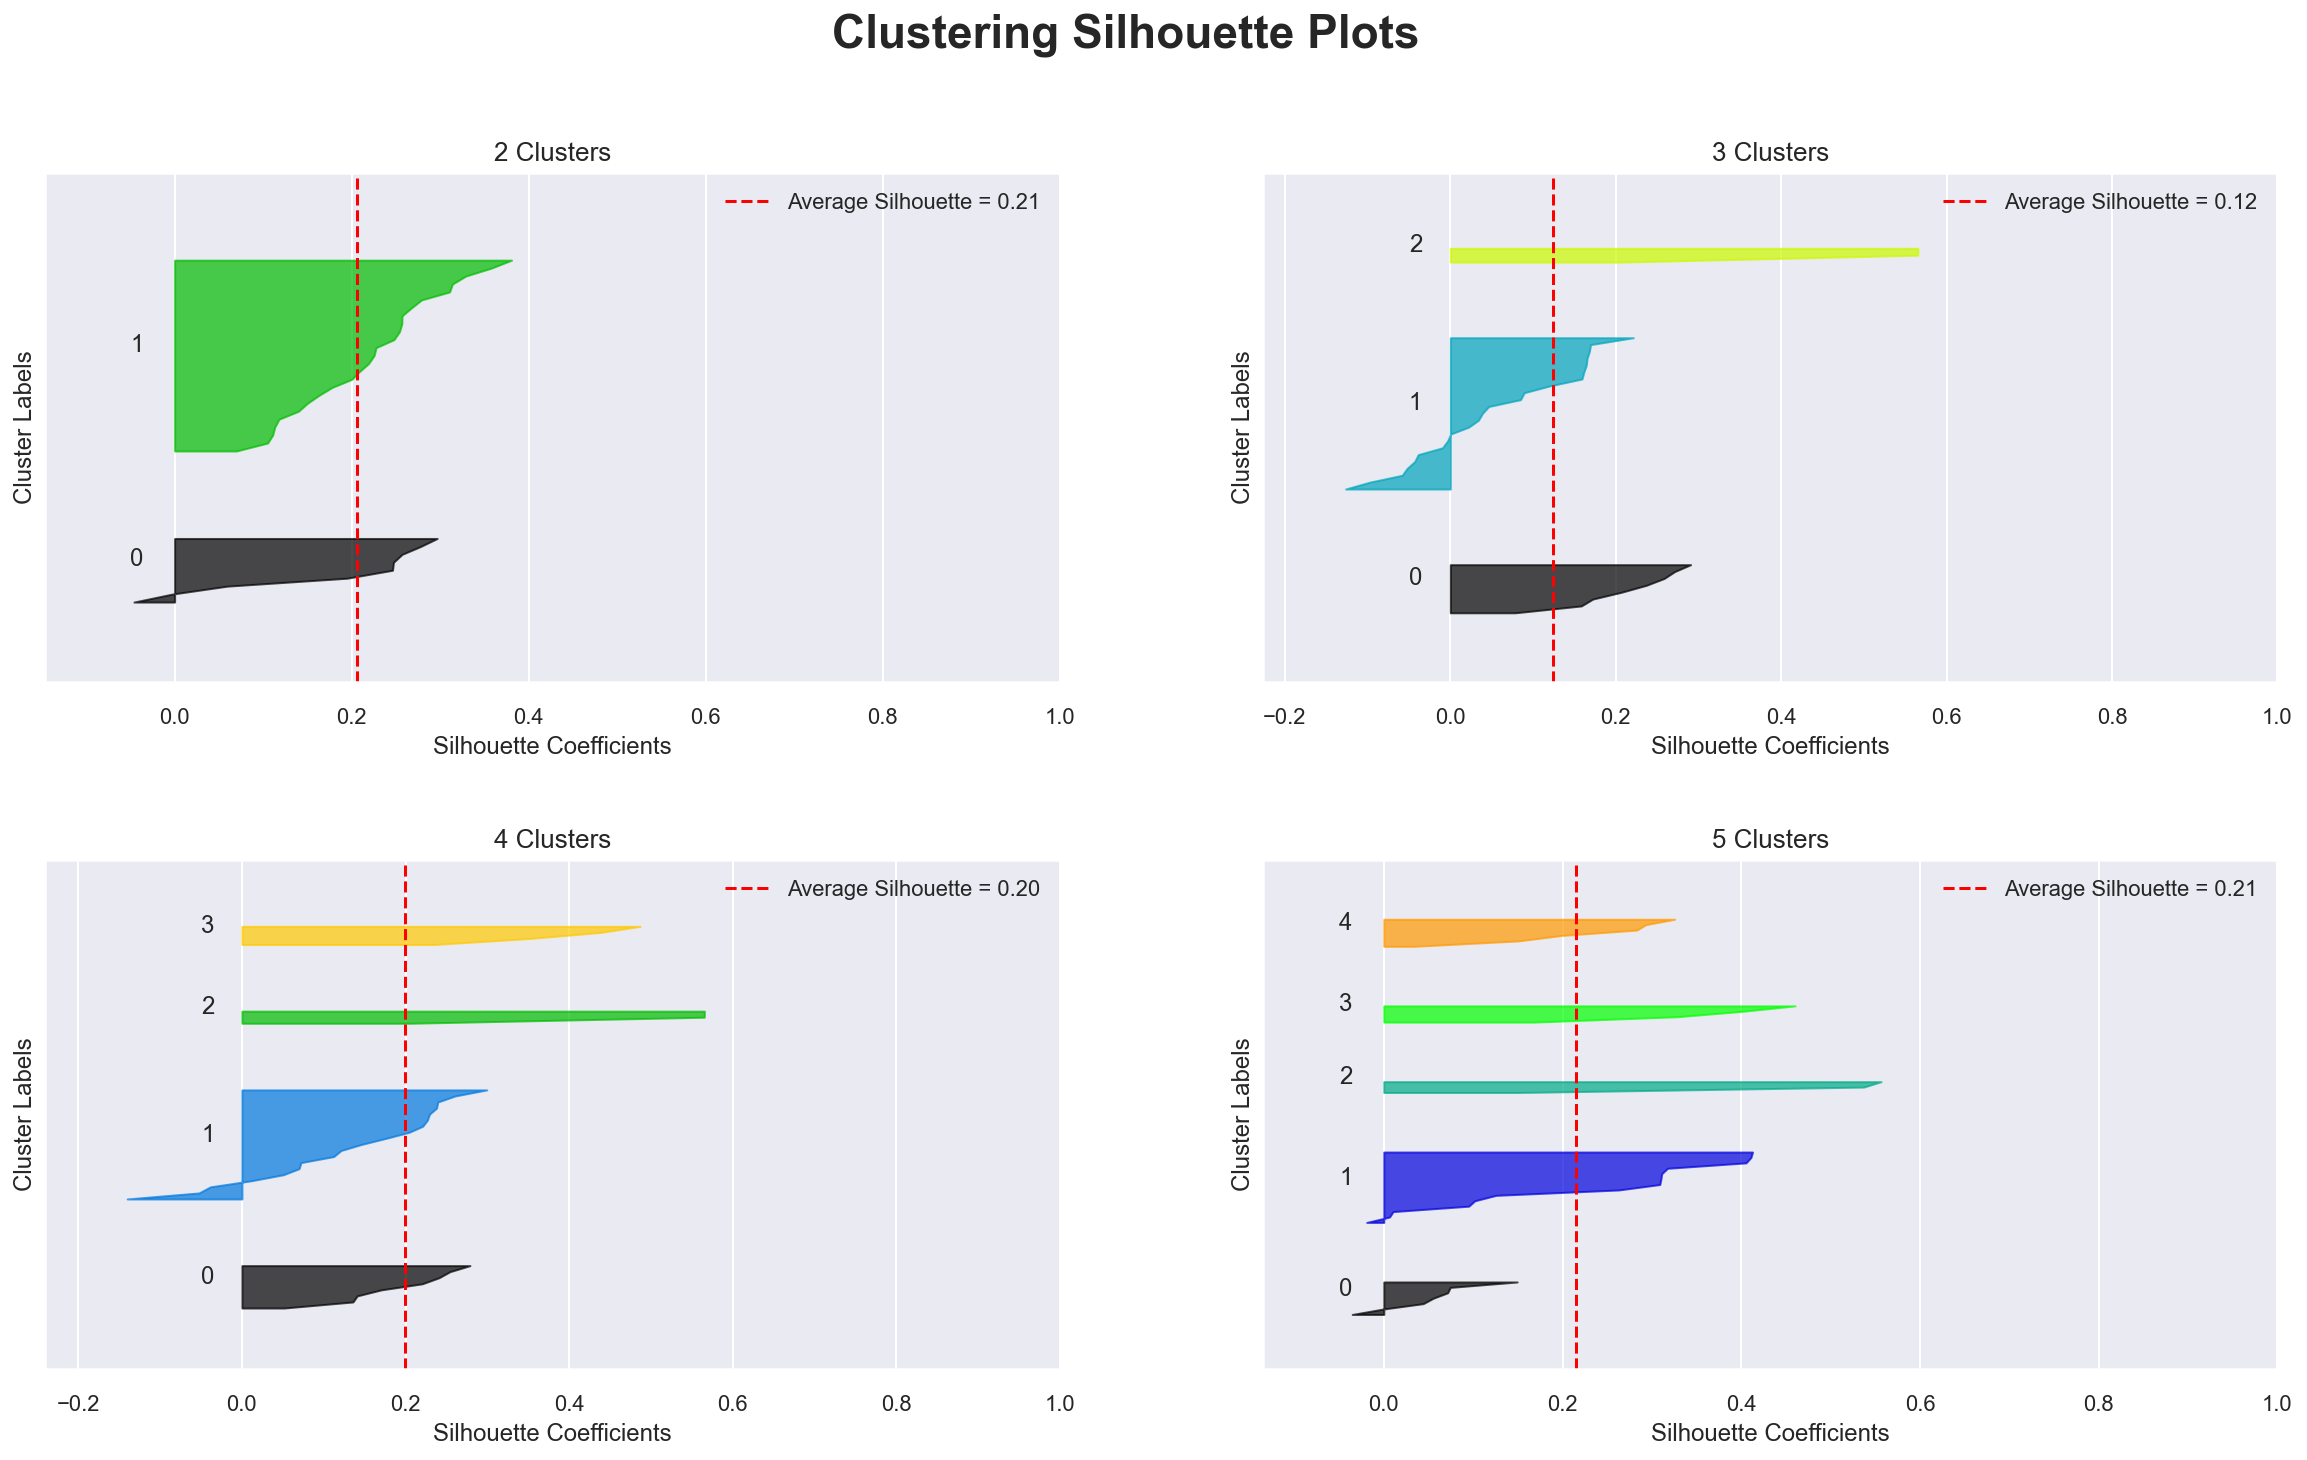

In [291]:
gmm = GaussianMixture(init_params='kmeans', random_state=0)
silhouette_analysis(data_clust_test, gmm, (2,2), (20,11), max_nclus=6)

In [292]:
#the gmm method was aggregated on a function
def doGMM(df, nclust):
    model=GaussianMixture(n_components=nclust, init_params='kmeans', random_state=0)
    model.fit(df)
    clust_labels = model.predict(df)
    return(clust_labels)

In [293]:
# Performing gmm and appending the cluster labels to a new dataframe that keeps the cluster labels
clust_labels = doGMM(data_clust_test, 5)
gmm_data_clust_test = data_clust_test.copy()
gmm_data_clust_test["gmm_labels"] = clust_labels

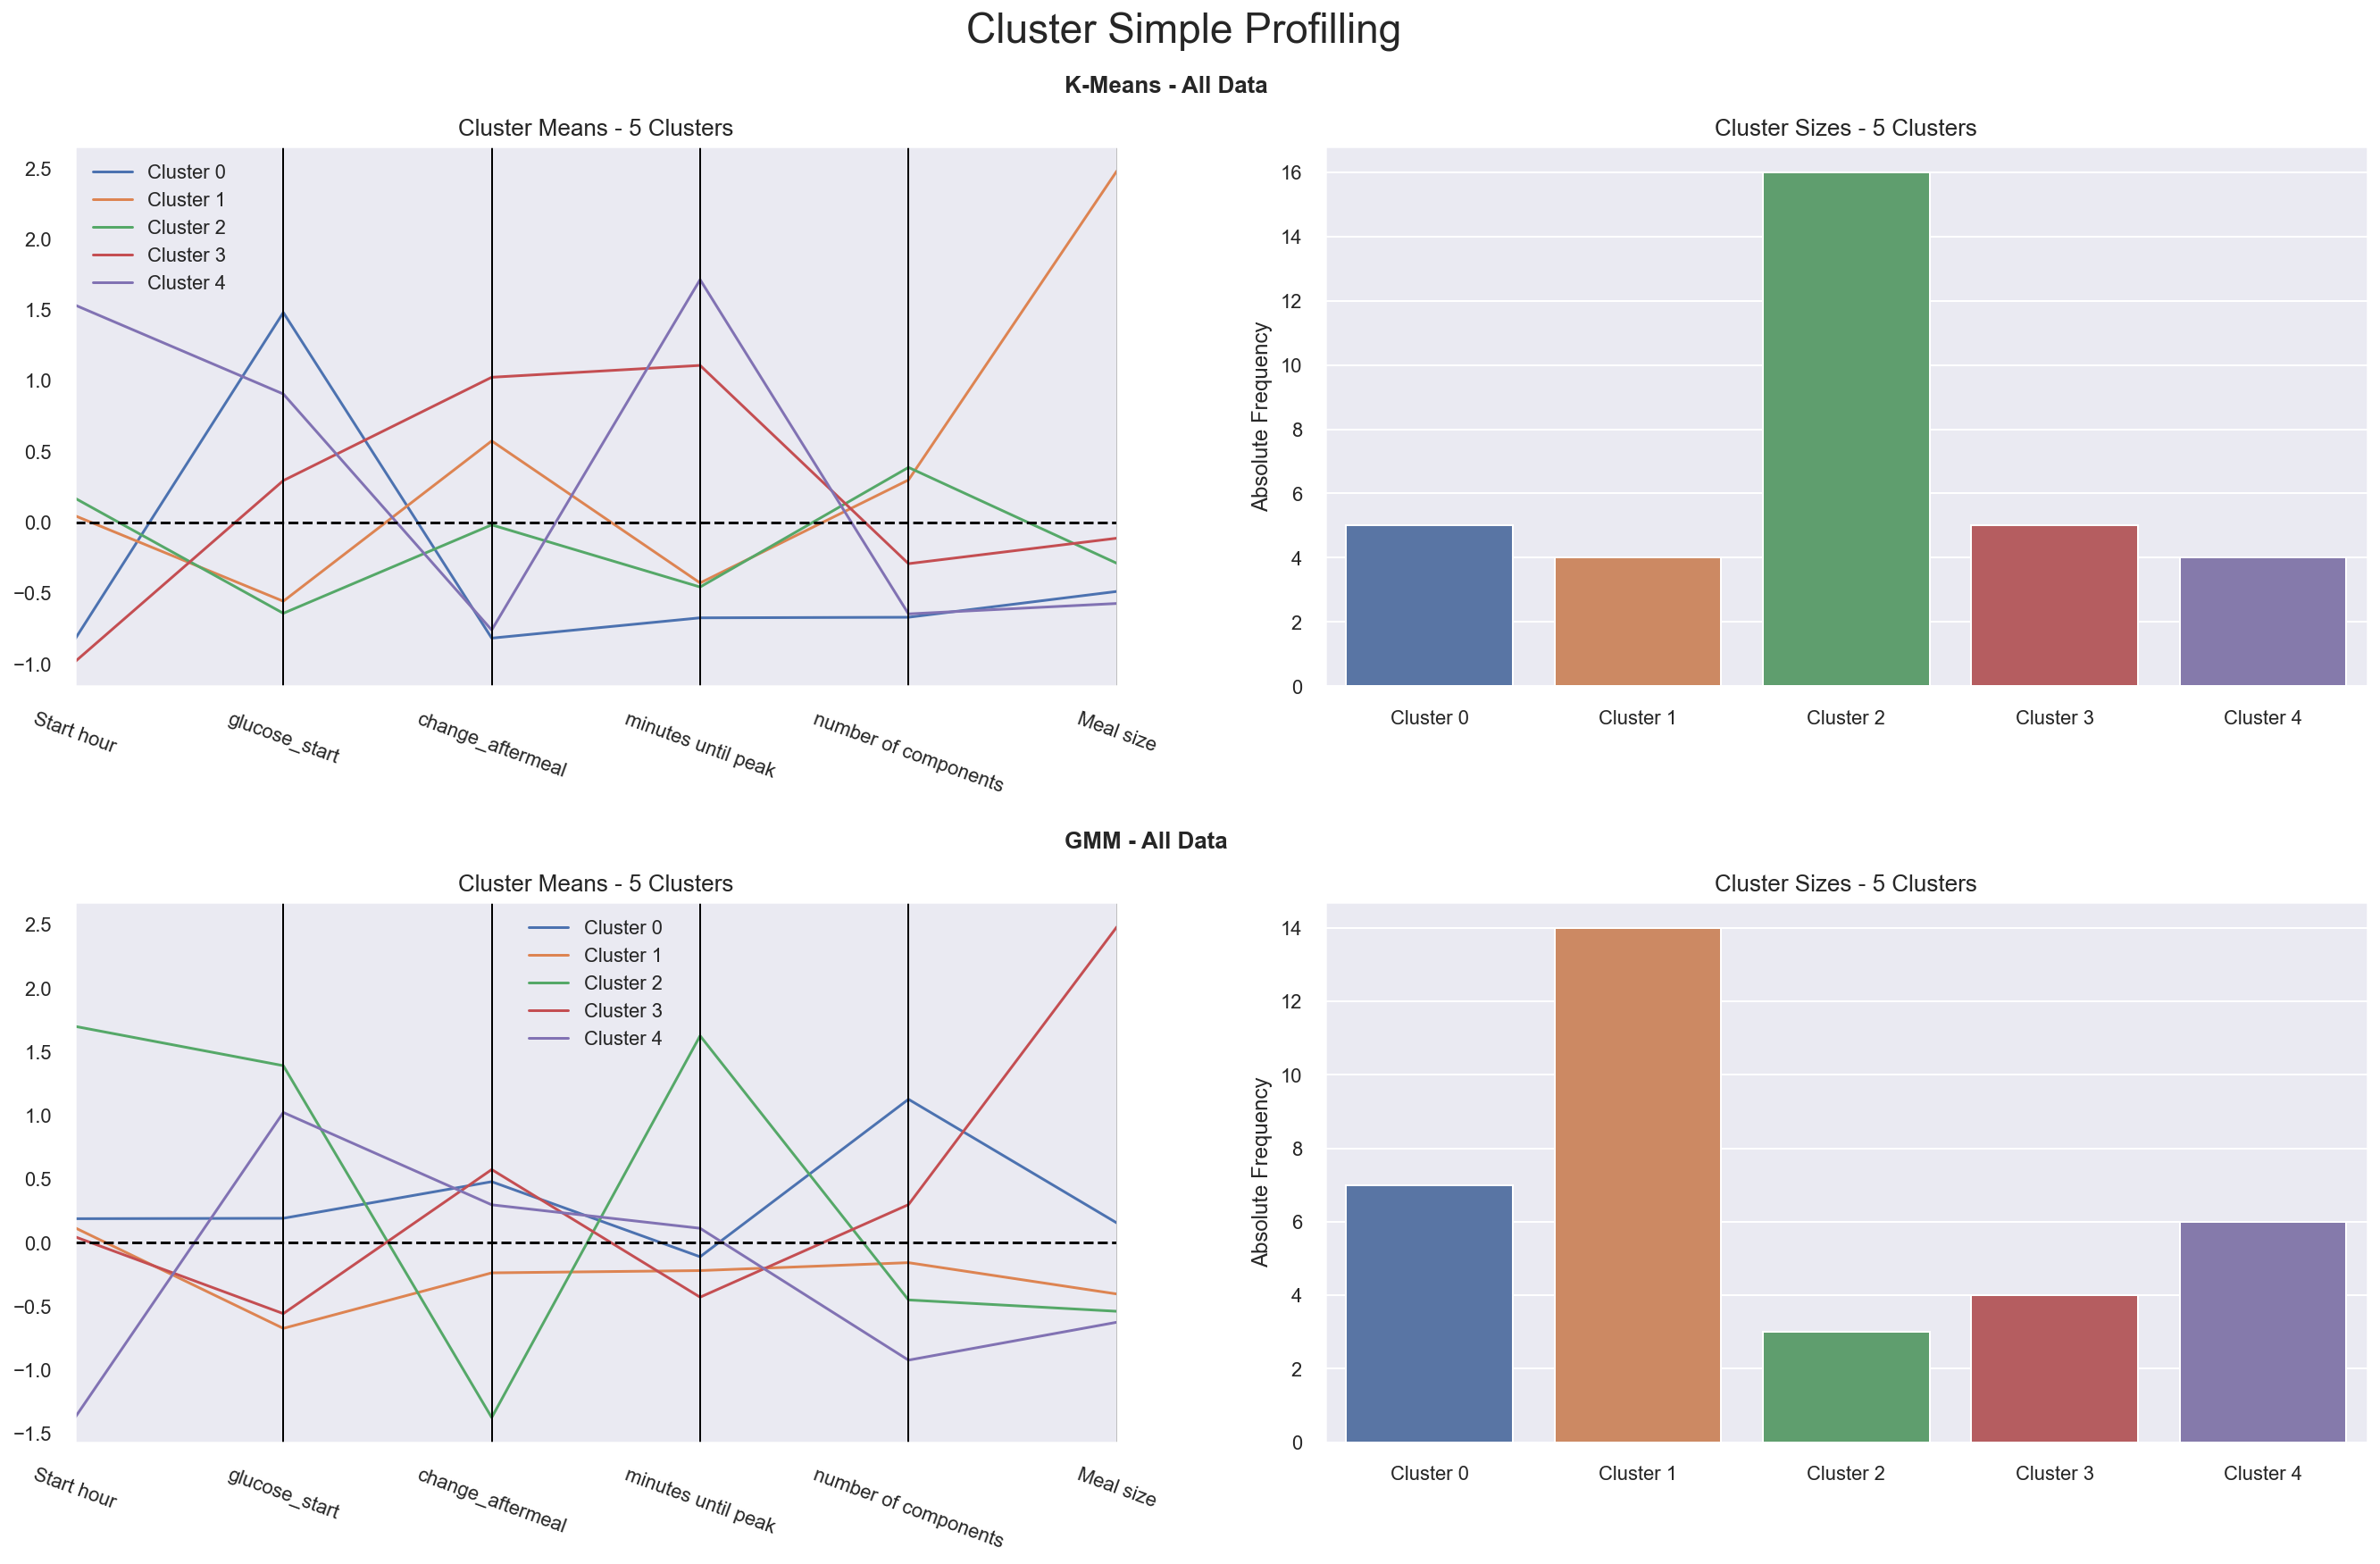

In [294]:
# Comparing both K-means and GMM solutions
comp_data_clust_test = kmeans_data_clust_test.merge(gmm_data_clust_test["gmm_labels"], left_index=True, right_index=True)
cluster_profiles(comp_data_clust_test, ["kmeans_labels", "gmm_labels"], figsize=(23, 13), compar_titles=["K-Means - All Data", "GMM - All Data"])

- Comparing both solutions illustrates that the choice of clustering algorithm can influence the results (althought there should also be a degree of similarity has they are learning from the same data).
- For both cases, the largest cluster (2 with kmeans and 1 with GMM) show similar patterns: Average start hour, low levels of glucose at the beggining, average increase in glucose after the meal, slightly lower time until peak glucose than the average and smaller meal size.
- Cluster 1 in kmeans also seems to correspond to cluster 3 in GMM: very high meal size, above average number of components in the meal, lower time for glucose to peak, moderate glucose increase after meal, low glucose start and average start hour.
- Cluster 4 in kmeans seems to correspond to cluster 2 in GMM: meals that start much later, with glucose high at the start, low impact on glucose increase, longer time to reach glucose peak after the meal, low number of components and smaller meal size.

### By groupping meals into clusters we can try to uncover characteristics that are shared between these meals and use the grouping to classify meals as better or worse for the user. For example, meals in cluster 4 of kmeans or clustewr 2 of GMM seem to have less of an effect on glucose and thuis could be preferred. Clustering could also be used to group meals together according to the nutrients that the food contains.


## Using SOMs (Self-Organizing Maps) to show how they can be used to understand relationship between variables and perform clustering combining with hierarchical clustering

In [318]:
#Producing SOM clustering 
sm = sompy.SOMFactory().build(data=data_clust_test.values, 
                        mapsize=(10,10),
                        normalization='var',
                        initialization='random',
                        component_names=data_clust_test.columns,
                        lattice='hexa',
                        training='seq')

sm.train(n_job=4,
         verbose=None,
         train_rough_len=100,
         train_finetune_len=100)

In [319]:
#Obtaining SOM's BMUs labels
som_data_clust_test = pd.DataFrame(np.concatenate((sm._data, np.expand_dims(sm._bmu[0],1)), axis=1),
                               index=data_clust_test.index, columns=np.append(data_clust_test.columns,"labels_som"))

sm.calculate_quantization_error()

0.3143937665382826

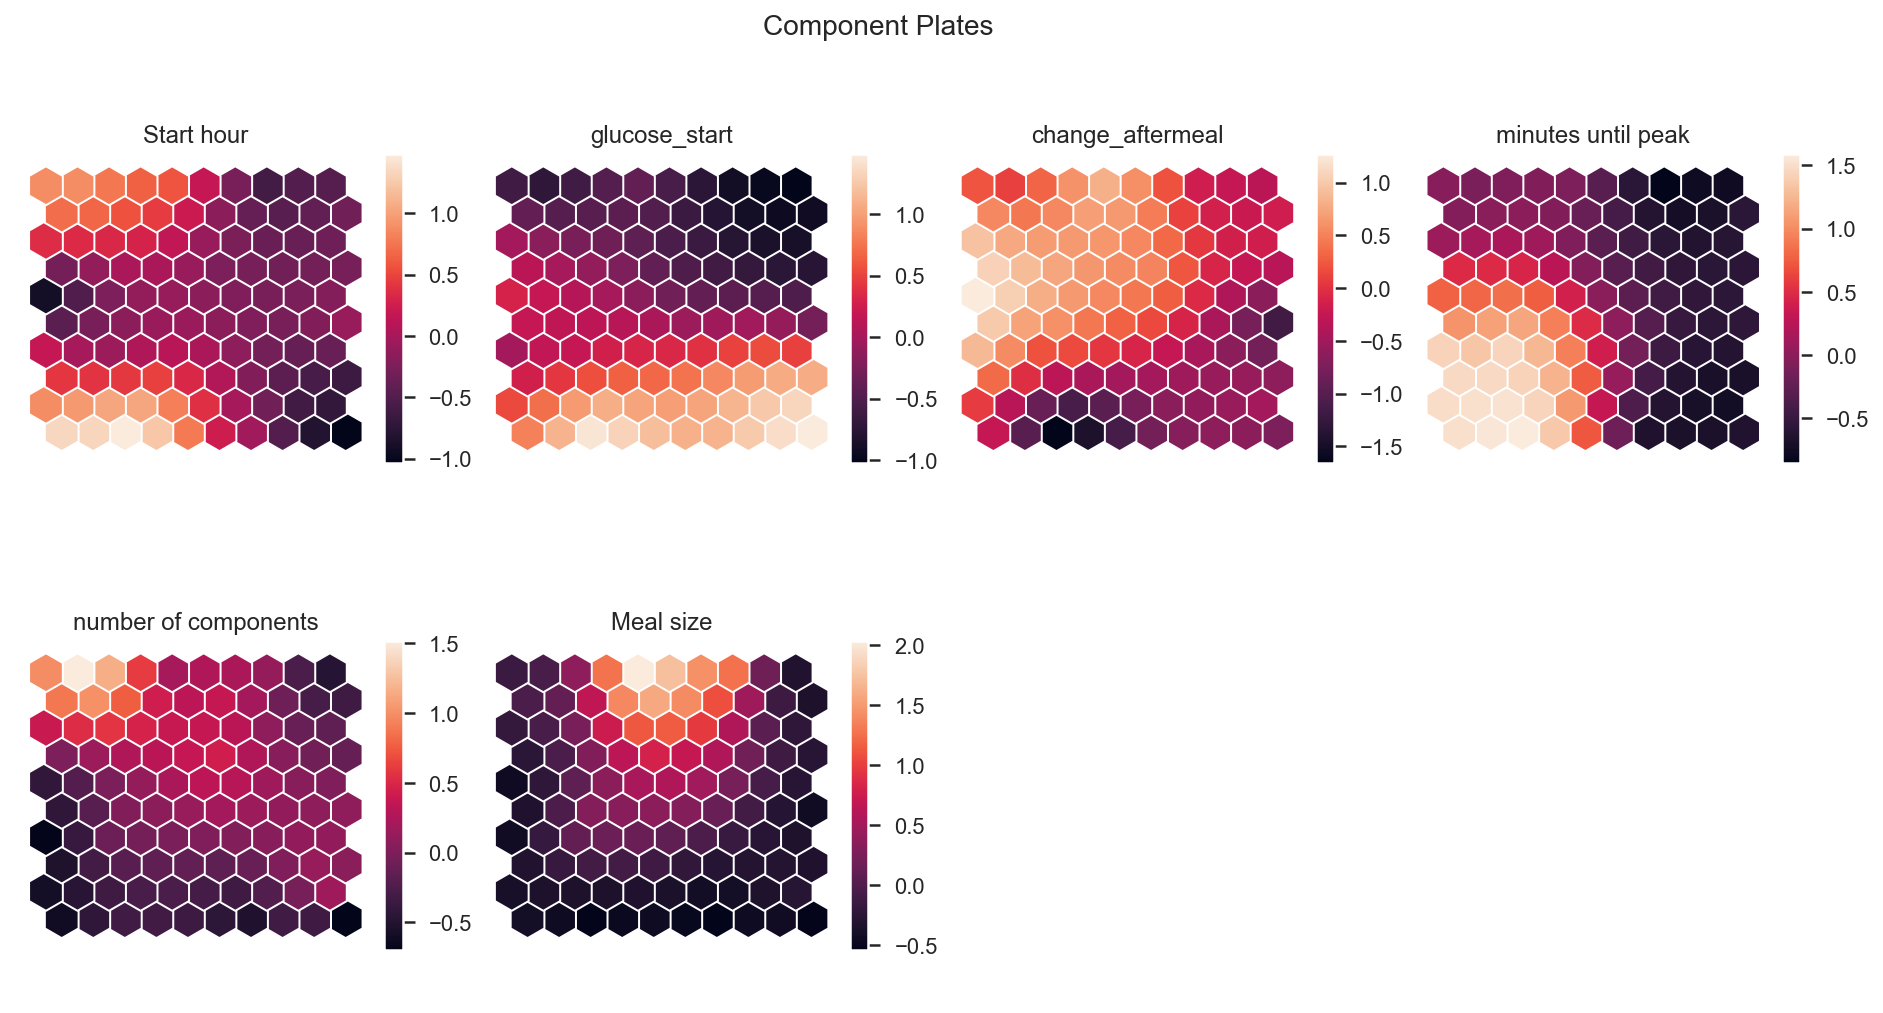

In [320]:
# Visualizing the Component plates (feature values)
sns.set()
view2D = View2D(12,12,"", text_size=8)
view2D.show(sm, col_sz=4, what='codebook')
plt.subplots_adjust(top=0.90)
plt.suptitle("Component Plates", fontsize=14)
plt.show()

- This can be used to visualize relationship between variables.
- For example, we can see that the darkest reagion in the variable change aftermeal (meaning the increase in glucose is lower that the average) corresponds to meals with the brightest region of the variable minutes until peak (meaning more time until the glucose peak is reached).
- Another example is that the brightest areas of teh number of components and meal size are in the same region (these correspond to meal with many types of food and overall larger portions)

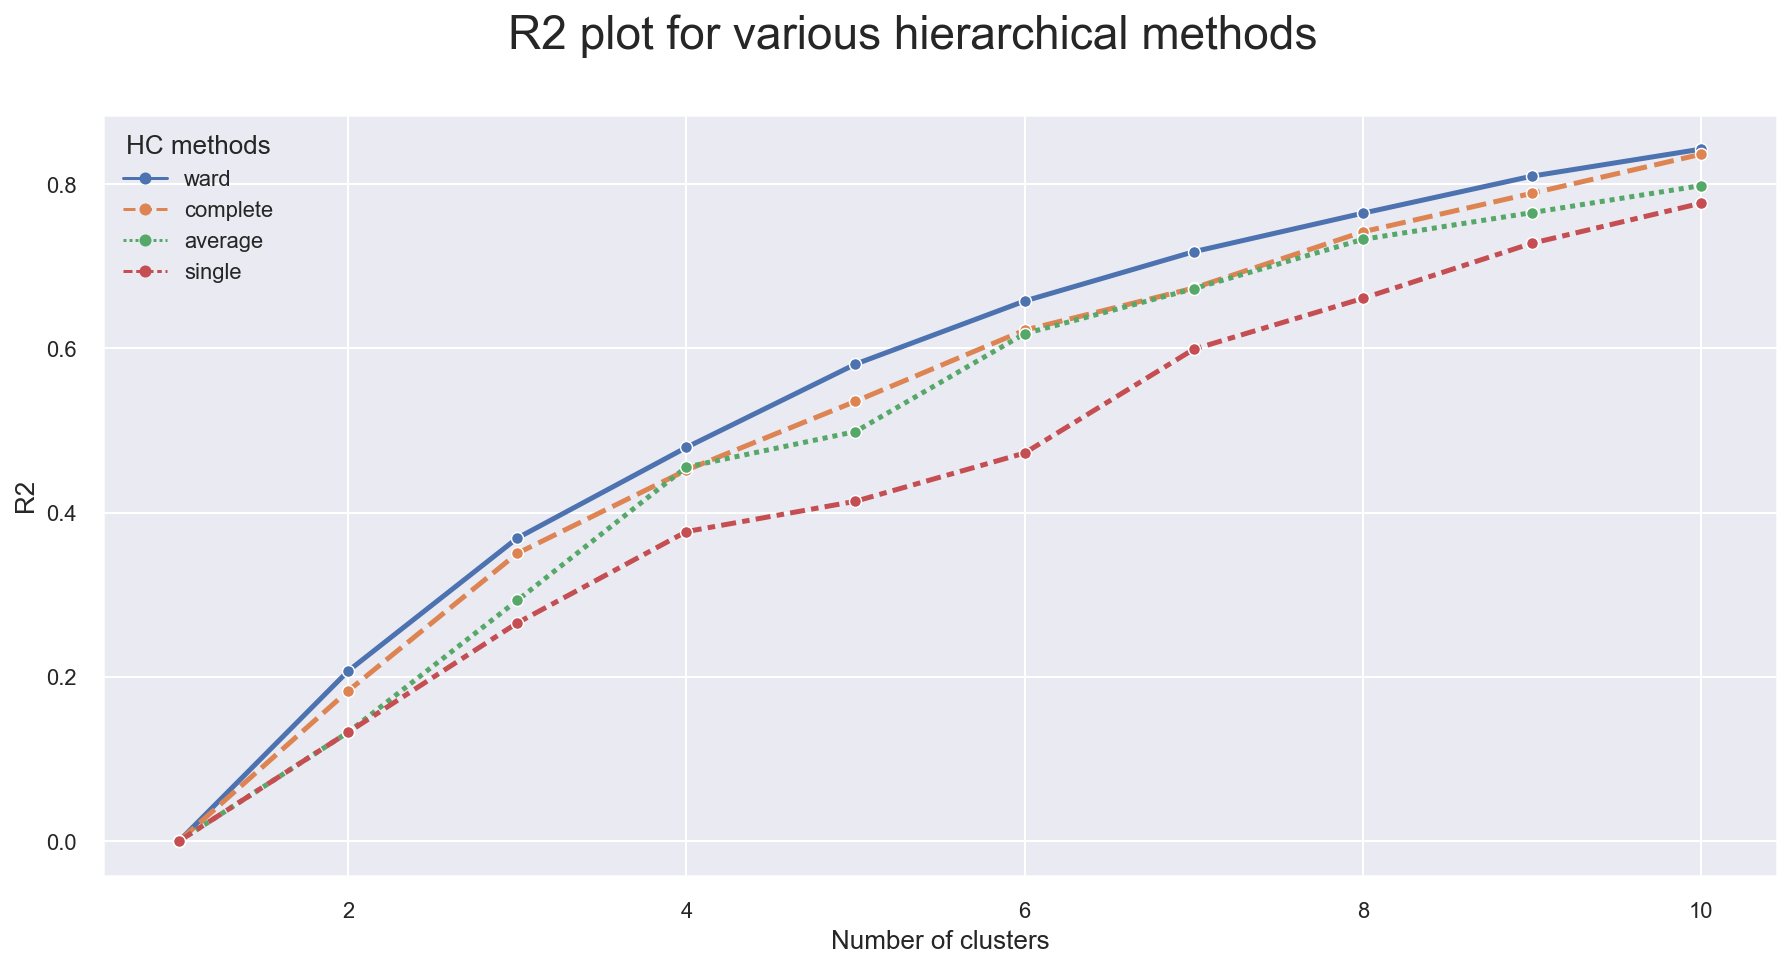

In [321]:
# Getting the centroids of each cluster given by the BMUs of each observation
som_units = som_data_clust_test.groupby("labels_som").mean()

# Prepare input
hc_methods = ["ward", "complete", "average", "single"]
# Function defined above to obtain the R2 statistic
r2_hc_methods = pd.DataFrame(data=np.concatenate([np.expand_dims(get_r2_hc(df=som_units, link=i, max_nclus=10), 1) for i in hc_methods], axis=1),
                             index=range(1,10+1), columns=hc_methods)

sns.set()
# Plot data
fig = plt.figure(figsize=(15,7))
sns.lineplot(data=r2_hc_methods, linewidth=2.5, markers=["o"]*4)

# Finalize the plot
fig.suptitle("R2 plot for various hierarchical methods", fontsize=23)
#plt.gca().invert_xaxis()
plt.legend(title="HC methods", title_fontsize=13)
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R2", fontsize=13)

plt.show()

In [322]:
som_units.head()

,Start hour,glucose_start,change_aftermeal,minutes until peak,number of components,Meal size
labels_som,,,,,,
0.0,-0.548406,-1.108447,-0.419958,-0.836844,-0.646770,-0.505548
2.0,-1.143484,-0.988169,-0.501705,-1.360761,0.653724,3.062436
5.0,0.840111,-0.266499,1.078746,0.044027,-0.055636,2.674034
8.0,1.038470,-1.088401,-0.365459,-0.209296,2.545352,-0.222000
9.0,1.038470,-0.687473,0.043278,0.067056,0.653724,-0.278857


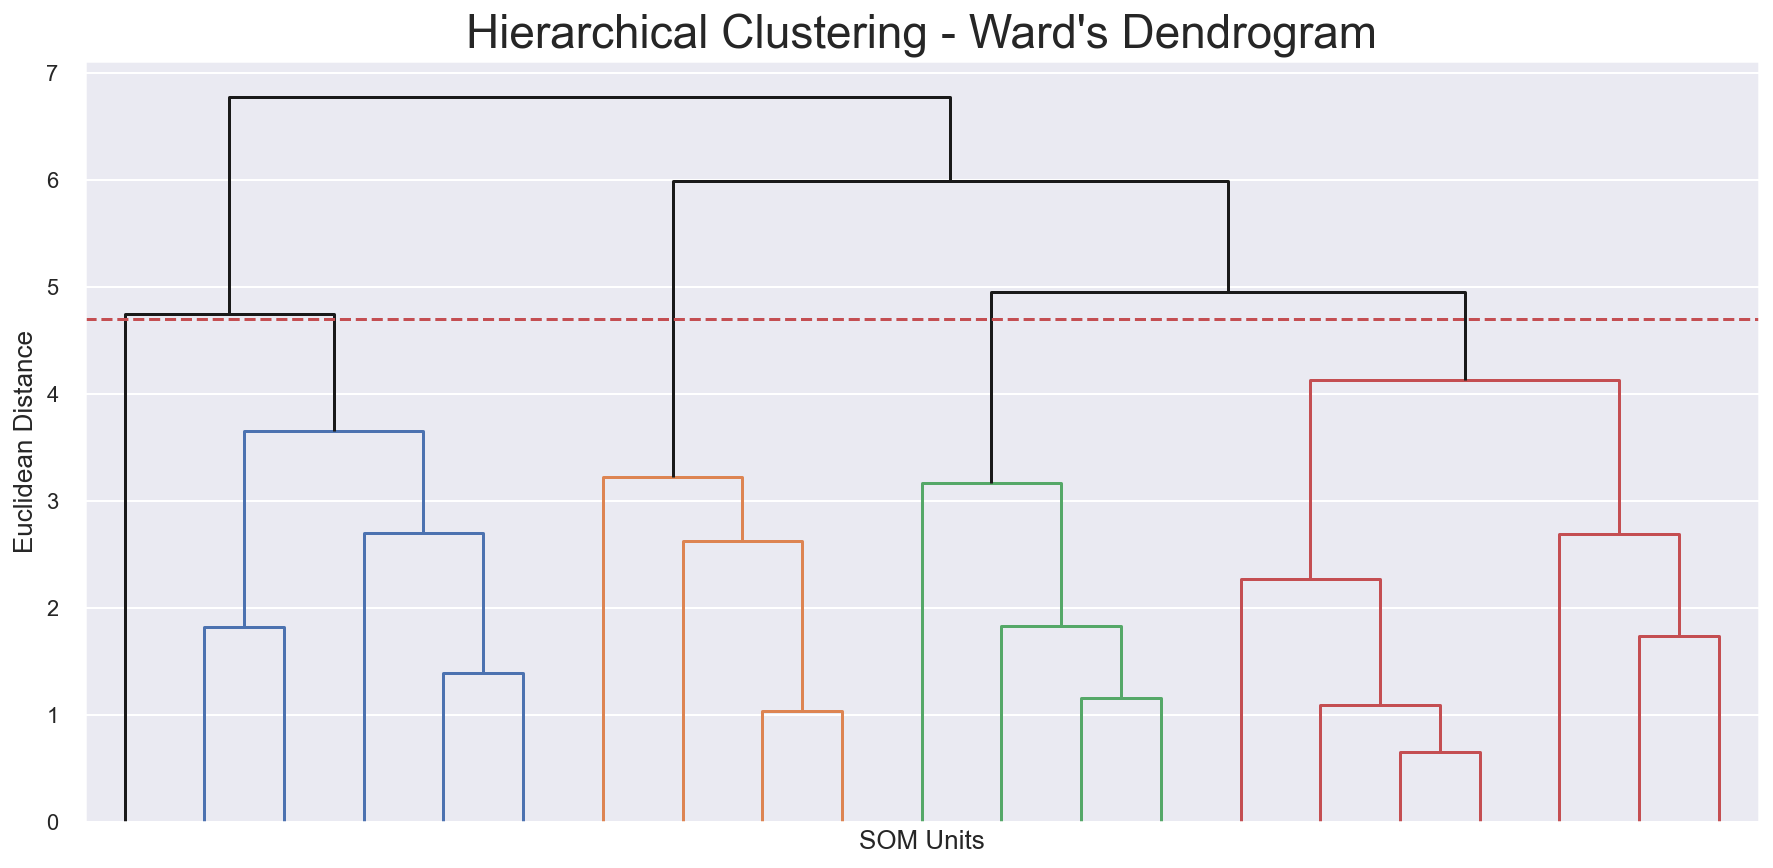

In [323]:
# Defining method to use
HCM = "ward"

# Hierarchical clustering assessment using scipy
Z = linkage(som_units, method=HCM)

sns.set()
fig = plt.figure(figsize=(15,7))

# Dendrogram
set_link_color_palette(list(sns.color_palette().as_hex()))
dendrogram(Z, color_threshold=4.7, orientation='top', no_labels=True, above_threshold_color='k')

plt.hlines(4.7, 0, 100000, colors="r", linestyles="dashed")
plt.title('Hierarchical Clustering - Ward\'s Dendrogram', fontsize=23)
plt.xlabel('SOM Units', fontsize=13)
plt.ylabel('Euclidean Distance', fontsize=13)
plt.show()

- This clustering strategy first groups meals in self-organizing maps and after merges the units using a hierarchical clustering algorithm (they are merged one by one according to the similarity.
- We chose a 5 cluster solution to be consistent with the previous clustering examples.

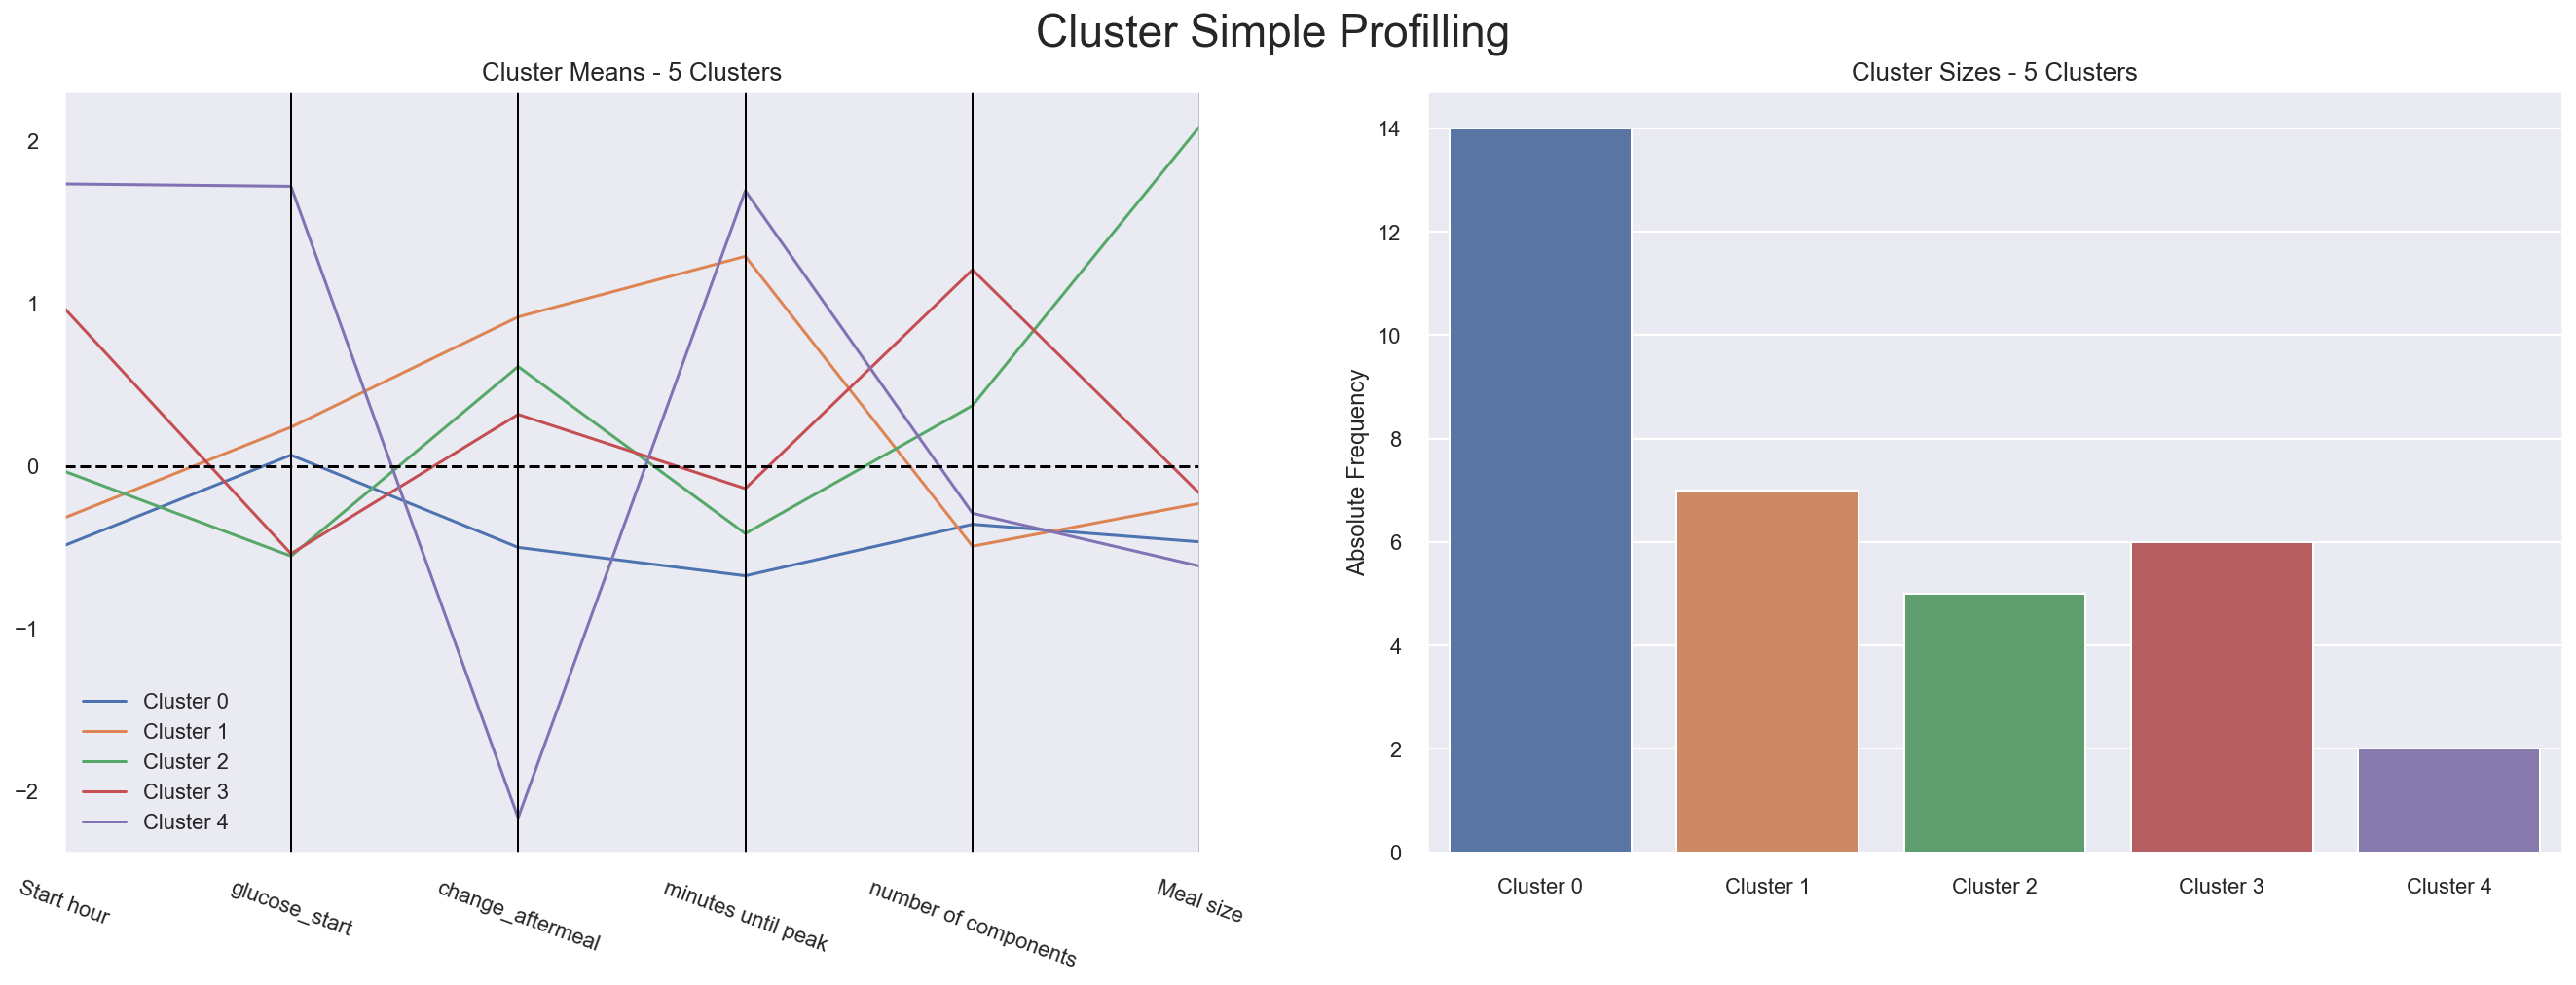

In [324]:
# Defining numbers of clusters
CLUSN = 5

# Hierarchical Clustering with sklearn
estimator = AgglomerativeClustering(n_clusters=CLUSN, linkage=HCM)
labels = estimator.fit_predict(som_units)

# Getting the HC labels for each SOM Unit
som_units_hc = pd.DataFrame(np.concatenate((som_units.values, np.expand_dims(labels,1)), axis=1), 
                            index=som_units.index, columns=np.append(som_units.columns,["labels_som_hc_4"]))

# Getting the HC labels for each observation in the main dataframe
som_data_clust_test = som_data_clust_test.merge(right=som_units_hc.loc[:,"labels_som_hc_4"], 
                                           left_on="labels_som", right_index=True).sort_index()
# Cluster Simple Profilling
cluster_profiles(som_data_clust_test.drop("labels_som", axis=1), ["labels_som_hc_4"], (23, 7))

In [325]:
#Summarizing results in original scale
SOM_summary = data_clust_test.copy()
SOM_summary["labels_som_hc_4"]= som_data_clust_test["labels_som_hc_4"]
SOM_summary = pd.concat([SOM_summary["labels_som_hc_4"], df_clustering], axis=1).dropna()
SOM_summary.groupby("labels_som_hc_4")[metric_features].mean().round(2)

,Start hour,glucose_start,change_aftermeal,minutes until peak,number of components,Meal size
labels_som_hc_4,,,,,,
0.0,11.29,106.29,29.0,54.71,2.86,142.57
1.0,12.14,110.57,55.0,140.00,2.57,302.71
2.0,13.60,90.80,49.4,66.00,4.40,1871.60
3.0,18.67,91.17,44.0,78.00,6.17,343.50
4.0,22.50,147.50,-1.5,157.50,3.00,41.50


- We could infer that the 'worst' meals are in cluster 1: high increase in glucose after meal, long time until glucose peaks, meals that are taken earlier than average, glucose is already slightly higher at the start.
- On the other hand, meals in cluster 0 or 4 seem to be the better options as they do not cause glucose to spike as much. 

### Important note: Interpreting results of clustering with so little observations is of course not  reccomended from a scientific standpoint, the observation made these far are, once again, purely exploratory and intend only to demostarte how one could use the visuals and clustering techniques to draw conclusions.

In [329]:
#A look at how each meal was classified
SOM_summary

,labels_som_hc_4,Start hour,record_type,glucose_start,change_aftermeal,minutes until peak,number of components,Meal size
0,2.0,8,BREAKFAST,80.0,29.0,25.0,5,2533
1,0.0,12,LUNCH,83.0,38.0,59.0,4,277
2,0.0,16,SNACK,73.0,29.0,42.0,2,0
3,3.0,19,DINNER,73.0,28.0,111.0,12,313
4,0.0,8,BREAKFAST,78.0,30.0,36.0,3,335
5,0.0,12,LUNCH,83.0,33.0,67.0,3,262
6,3.0,19,DINNER,82.0,35.0,39.0,6,305
7,0.0,8,BREAKFAST,81.0,28.0,47.0,2,130
8,0.0,12,LUNCH,76.0,35.0,66.0,2,3
9,0.0,15,SNACK,87.0,5.0,63.0,4,52


# Prediction

With a similar dataset one could model the relationship between meal composition and a target such as glucose response. This would allow to study questions such as:
- Ability to predict glucose response to meals based on its nutritional composition
- How the characteristics of a person are related to the profile of glucose response to certain meal or nutrients

# THANK YOU FOR YOUR TIME! 